# Hubble Source Catalog SWEEPS Proper Motion Notebook
### June 2019, Steve Lubow and Rick White

This notebook shows how to access the new proper motions available for the [SWEEPS](https://media.stsci.edu/news_release/news/2011-16) field in version 3.1 of the [Hubble Source Catalog](https://archive.stsci.edu/hst/hsc).  Data tables in [MAST CasJobs](https://mastweb.stsci.edu/hcasjobs) are queried from Python using the [mastcasjobs](https://github.com/rlwastro/mastcasjobs) module.  Additional information is available on the 
[SWEEPS Proper Motions help page](https://archive.stsci.edu/hst/hsc/help/sweeps/hsc_sweeps_pm.html).

This notebook is available for [download](sweeps_hscv3p1.ipynb).

# Instructions: 
* Complete the initialization steps [described below](#Initialization).
* Run the notebook to completion. 
* Modify and rerun any sections of the Table of Contents below.

Running the notebook from top to bottom takes about 7 minutes (depending on the speed of your computer).


# Table of Contents
* [Intialization](#Initialization)
* [Properties of Full Catalog](#fullcat)
    * [Sky Coverage](#SkyCoverage)
    * [Proper Motion Distributions](#pmhist)
    * [Visit Distribution](#visitshist)
    * [Time Coverage Distributions](#timehist)
    * [Magnitude Distributions](#maghist) 
    * [Color Magnitude Diagram](#cmdall)
    * [Detection Positions](#detpos)
* [Good Photometric Objects](#goodphot)
* [Science Applications](#sciap)
    * [Proper Motions on the CMD](#goodpm)
    * [Proper Motions in Bulge Versus Disk](#bulgedisk)
    * [White Dwarfs](#wd)
    * [QSO Candidates](#qsocan)
    * [High Proper Motion Objects](#hpm)
    * [HLA Cutout Images for Selected Objects](#cutouts)

# Initialization <a class="anchor" id="Initialization"></a>

### Install Python modules

_This notebook requires the use of **Python 3**._

This needs some special modules in addition to the common requirements of `astropy`, `numpy` and `scipy`.  For anaconda versions of Python the installation commands are:

<pre>
conda install requests
pip install git+git://github.com/dfm/casjobs@master
pip install git+git://github.com/rlwastro/mastcasjobs@master
pip install fastkde
</pre>

If you already have an older version of the `mastcasjobs` module, you may need to update it:

<pre>
pip install --upgrade git+git://github.com/rlwastro/mastcasjobs@master
</pre>

### Set up your CasJobs account information

You must have a MAST Casjobs account (see https://mastweb.stsci.edu/hcasjobs to create one).  Note that MAST Casjobs accounts are independent of SDSS Casjobs accounts.

For easy startup, you can optionally set the environment variables `CASJOBS_USERID` and/or `CASJOBS_PW` with your Casjobs account information.  The Casjobs user ID and password are what you enter when logging into Casjobs.

This script prompts for your Casjobs user ID and password during initialization if the environment variables are not defined.

#### Other optional configuration

If desired, you can set `resPath`, the output directory, in the next code block (the default location is the current working directory, which is probably the same directory as this script).

In [1]:
resPath="./" # directory where generated plots are saved
HSCContext= "HSCv3"

%matplotlib inline
import astropy, pylab, time, sys, os, requests
import numpy as np
from matplotlib.colors import LogNorm

# check that version of mastcasjobs is new enough
# we are using some features not in version 0.0.1
from pkg_resources import get_distribution
from distutils.version import StrictVersion as V
assert V(get_distribution("mastcasjobs").version) >= V('0.0.2'), """
A newer version of mastcasjobs is required.
Update mastcasjobs to current version using this command:
pip install --upgrade git+git://github.com/rlwastro/mastcasjobs@master
"""

import mastcasjobs

## For handling ordinary astropy Tables
from astropy.table import Table
from astropy.io import fits, ascii

from fastkde import fastKDE
from scipy.interpolate import RectBivariateSpline
from astropy.modeling import models, fitting

# There are a number of relatively unimportant warnings that 
# show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

# Set page width to fill browser for longer output lines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# set width for pprint
astropy.conf.max_width = 150

Set up Casjobs environment.

In [2]:
import getpass
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = input('Enter Casjobs UserID:')
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = getpass.getpass('Enter Casjobs password:')

### Create table in MyDB with selected SWEEPS objects

Note that the query restricts the sample to matches with at least 10 detections in each of F606W and F814W.  This can be modified depending on the science goals.

This uses an existing MyDB.SWEEPS table if it already exists in your CasJobs account.  If you want to change the query, either change the name of the output table or drop the table to force it to be recreated.  Usually the query completes in about a minute, but if the database server is heavily loaded then it can take much longer.

In [3]:
DBtable = "SWEEPS"
jobs = mastcasjobs.MastCasJobs(context="MyDB")

try:
    print("Retrieving table MyDB.{} (if it exists)".format(DBtable))
    tab = jobs.fast_table(DBtable, verbose=True)
except ValueError:
    print("Table MyDB.{} not found, running query to create it".format(DBtable))

    # drop table if it already exists
    jobs.drop_table_if_exists(DBtable)

    #get main information
    query = """
        select a.ObjID,  RA=a.raMean, Dec=a.decMean, RAerr=a.raMeanErr, Decerr=a.decMeanErr,
            c.NumFilters, c.NumVisits,
            a_f606w=i1.MagMed,  a_f606w_n=i1.n, a_f606w_mad=i1.MagMAD,
            a_f814w=i2.MagMed, a_f814w_n=i2.n, a_f814w_mad=i2.MagMAD,
            bpm=a.pmLat, lpm=a.pmLon, bpmerr=a.pmLatErr, lpmerr=a.pmLonErr,
            pmdev=sqrt(pmLonDev*pmLonDev+pmLatDev*pmLatDev),
            yr=(a.epochMean - 47892)/365.25+1990, 
            dT=(a.epochEnd-a.epochStart)/365.25,
            yrStart=(a.epochStart - 47892)/365.25+1990,
            yrEnd=(a.epochEnd - 47892)/365.25+1990
        into mydb.{}
        from AstromProperMotions a join AstromSumMagAper2 i1 on 
             i1.ObjID=a.ObjID and i1.n >=10 and i1.filter ='F606W' and i1.detector='ACS/WFC'
         join AstromSumMagAper2 i2 on 
             i2.ObjID=a.ObjID and i2.n >=10 and i2.filter ='F814W' and i2.detector='ACS/WFC'
         join AstromSumPropMagAper2Cat c on a.ObjID=c.ObjID
    """.format(DBtable)

    t0 = time.time()
    jobid = jobs.submit(query, task_name="SWEEPS", context=HSCContext)
    print("jobid=",jobid)
    results = jobs.monitor(jobid)
    print("Completed in {:.1f} sec".format(time.time()-t0))
    print(results)

    # slower version using CasJobs output queue
    # tab = jobs.get_table(DBtable, verbose=True)
    
    # fast version using special MAST Casjobs service
    tab = jobs.fast_table(DBtable, verbose=True)

tab

Retrieving table MyDB.SWEEPS (if it exists)
Table MyDB.SWEEPS not found, running query to create it
jobid= 11815903
Completed in 20.3 sec
(5, 'finished')
16.3 s: Retrieved 157.86MB table MyDB.SWEEPS
30.5 s: Converted to 443932 row table


<Table length=443932>
    ObjID             RA                 Dec                RAerr        ...         dT              yrStart             yrEnd       
    int64          float64             float64             float64       ...      float64            float64            float64      
------------- ------------------ ------------------- ------------------- ... ------------------ ------------------ ------------------
4000709002286  269.7911379669984 -29.206156187411423  0.6964818624528099 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002287  269.7955922590832 -29.206151631494986 0.24020216760386343 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002288 269.81608933789283 -29.206155196641195  0.3040684131020671 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002289  269.8259694163096  -29.20615668840751  0.3564325426522067 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002290 269.83486415728754 -29.206155266983643 0.16299639839198538 ... 3.0067822490178155 2011.8013119543625 2014.8080942033803
4000709002291 269.83512411344606   -29.2061635244798 0.18282583105108072 ... 3.0067822490178155 2011.8013119543625 2014.8080942033803
4000709002292  269.7964913295107  -29.20618734483311 0.30491102397226527 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002293  269.7872745304419 -29.206257828852337   1.351885504360048 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002294 269.80888716219647 -29.206189189626002  1.4134596118752103 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002295  269.8234425365187 -29.206188473661626 0.35597857562160923 ... 11.298715372835678 2003.4361796620085 2014.7348950348442
          ...                ...                 ...                 ... ...                ...                ...                ...
4000946339500  269.6899686412092  -29.27697845186784  1.7581744127758168 ... 2.1913492111623043 2012.4990161054518 2014.6903653166141
4000946380565 269.71004704275265 -29.258318619418723  1.4337273570795164 ... 2.3094412747548714 2012.4990161054518 2014.8084573802066
4000946404892 269.67530078168915 -29.247162734242675  1.3763906949106726 ... 2.0458630494273624  2012.389031376682 2014.4348944261094
4000946417296  269.7016328152704 -29.246070466593743   3.130830982636958 ...   2.01948620036275 2012.6708791162512 2014.6903653166141
4000949430259   269.722986295747  -29.21197112017265   1.361963963773738 ...  6.212572361916957   2004.14378291216  2010.356355274077
4000949692413   269.847657491686 -29.213464437142868  2.3678034671958668 ... 1.5098539308761485 2013.2982402725042 2014.8080942033803
4000949719295  269.8230388680129  -29.20072120181885  6.9256239011552925 ... 10.768784408135662 2003.4361796620085 2014.2049640701443
4000979902333   269.804403240861 -29.192813265455396  2.3859956776447127 ... 2.5308665509739208 2012.2040284838704 2014.7348950348442
4000979908546  269.8156665822647 -29.189854516331526  0.9143748593616481 ... 1.6017431136587867 2013.2063510897215 2014.8080942033803
4000980227788  269.7998513044728  -29.19707771926519  1.8494859814888565 ... 11.371914541371764 2003.4361796620085 2014.8080942033803

# Properties of Full Catalog  <a class="anchor" id="fullcat"></a>

# Sky Coverage  <a class="anchor" id="SkyCoverage"></a>

Text(0.5, 0.93, '443,932 stars in SWEEPS')

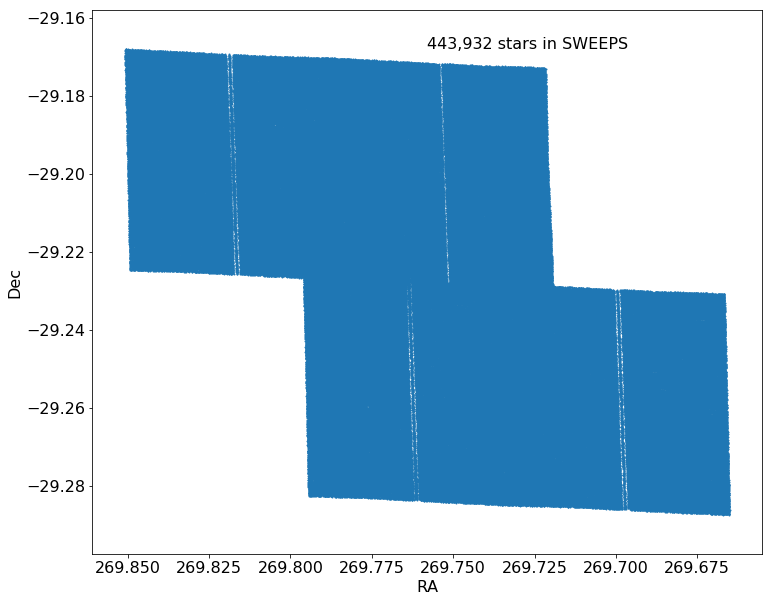

In [4]:
x = tab['RA']
y = tab['Dec']

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.scatter(x, y, s=1)
pylab.autoscale(tight=True)
pylab.xlabel('RA')
pylab.ylabel('Dec')
dc=0.01
pylab.xlim(min(x)-dc, max(x)+dc)
pylab.ylim(min(y)-dc, max(y)+dc)
pylab.gca().invert_xaxis()
pylab.text(0.5,0.93,'{:,} stars in SWEEPS'.format(len(x)),
       horizontalalignment='left',
       transform=pylab.gca().transAxes)

# Proper Motion Histograms <a class="anchor" id="pmhist"></a>

## Proper motion histograms for lon and lat 

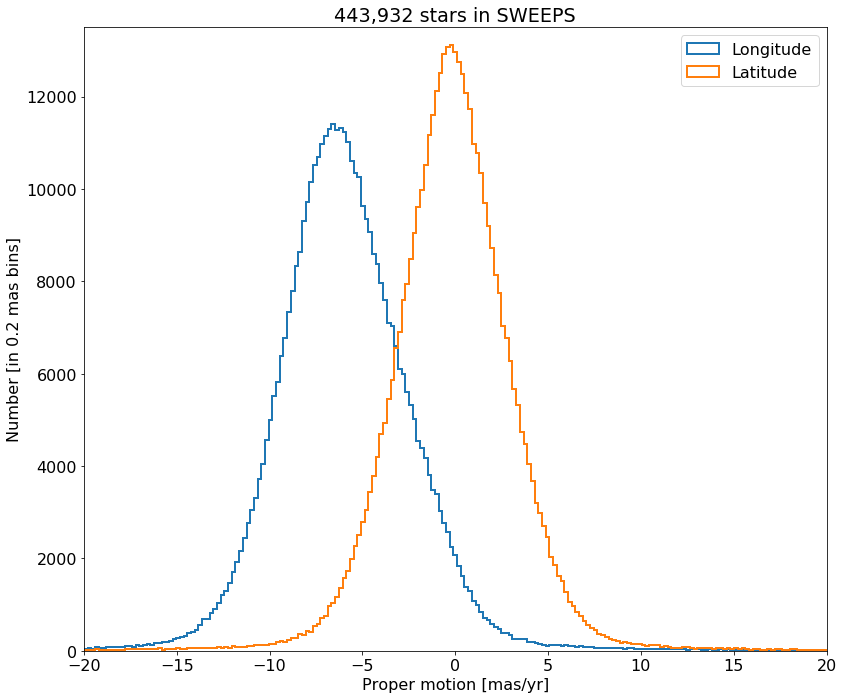

In [5]:
bin = 0.2
hrange = (-20,20)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.hist(tab['lpm'], range=hrange, bins=bincount, label='Longitude', 
           histtype='step', linewidth=2)
pylab.hist(tab['bpm'], range=hrange, bins=bincount, label='Latitude', 
           histtype='step', linewidth=2)
pylab.xlabel('Proper motion [mas/yr]')
pylab.ylabel('Number [in {:.2} mas bins]'.format(bin))
pylab.legend(loc='upper right')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.ylim(0,13500)
pylab.title('{:,} stars in SWEEPS'.format(len(tab)))
pylab.tight_layout()
pylab.savefig('{}sweeps_pmerr_hist.png'.format(resPath))

## Proper motion error cumulative histogram for lon and lat

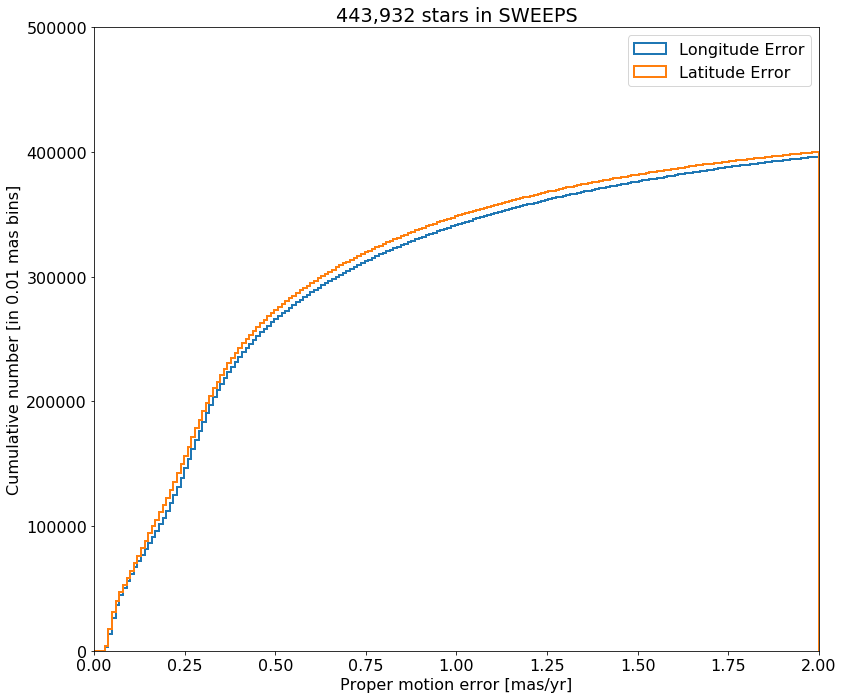

In [6]:
bin = 0.01
hrange = (0,2)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.hist(tab['lpmerr'], range=hrange, bins=bincount, label='Longitude Error', 
           histtype='step', cumulative=1, linewidth=2)
pylab.hist(tab['bpmerr'], range=hrange, bins=bincount, label='Latitude Error', 
           histtype='step', cumulative=1, linewidth=2)
pylab.xlabel('Proper motion error [mas/yr]')
pylab.ylabel('Cumulative number [in {:0.2} mas bins]'.format(bin))
pylab.legend(loc='upper right')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.ylim(0,500000)
pylab.title('{:,} stars in SWEEPS'.format(len(tab)))
pylab.tight_layout()
pylab.savefig('{}sweeps_pmerr_cumhist.png'.format(resPath))

## Proper motion error log histogram for lon and lat 

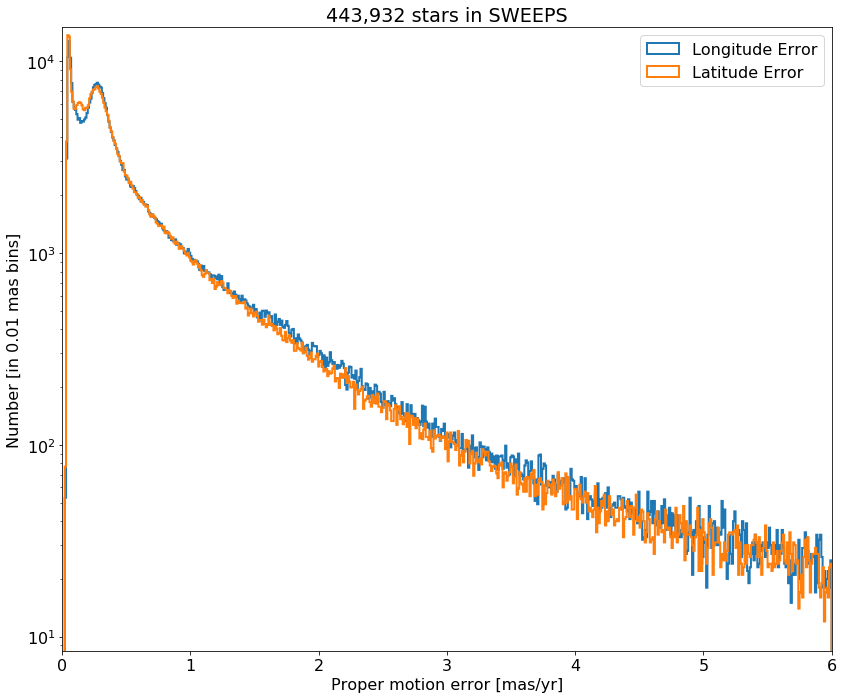

In [7]:
bin = 0.01
hrange = (0,6)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.hist(tab['lpmerr'], range=hrange, bins=bincount, label='Longitude Error', 
           histtype='step', linewidth=2)
pylab.hist(tab['bpmerr'], range=hrange, bins=bincount, label='Latitude Error', 
           histtype='step', linewidth=2)
pylab.xlabel('Proper motion error [mas/yr]')
pylab.ylabel('Number [in {:0.2} mas bins]'.format(bin))
pylab.legend(loc='upper right')
pylab.yscale('log')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.ylim(0,15000)
pylab.title('{:,} stars in SWEEPS'.format(len(tab)))
pylab.tight_layout()
pylab.savefig('{}sweeps_pmerr_loghist.png'.format(resPath))

### Proper motion error as a function of dT

Exclude objects with dT near zero, and to improve the plotting add a bit of random noise to spread out the quanitized time values.

kde took 4.3 sec
Plotting 178182 of 442682 points


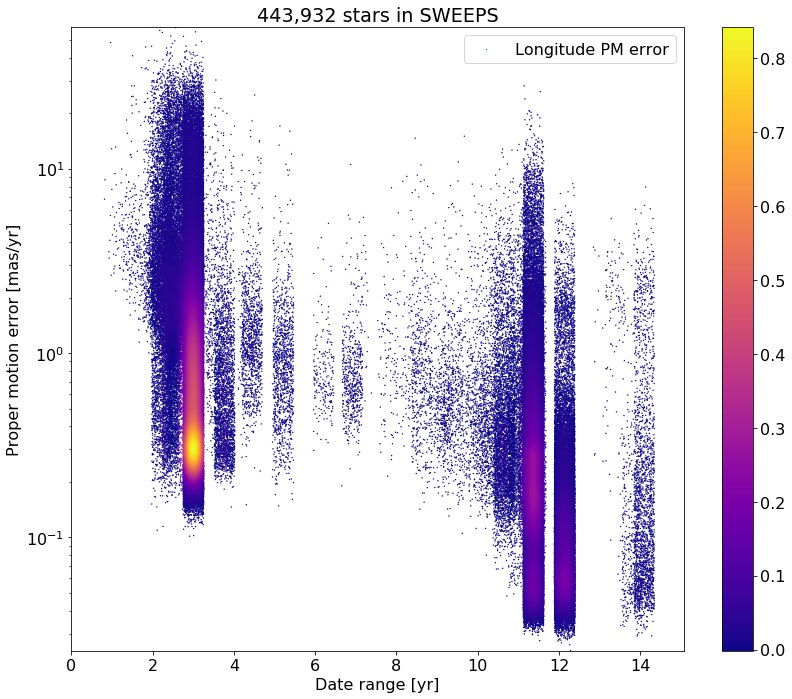

In [8]:
# restrict to sources with dT > 1 year
dtmin = 1.0
w = np.where(tab['dT']>dtmin)[0]
if ('rw' not in locals()) or len(rw) != len(w):
    rw = np.random.random(len(w))
x = np.array(tab['dT'][w]) + 0.5*(rw-0.5)
y = np.log(np.array(tab['lpmerr'][w]))

# Calculate the point density
t0 = time.time()
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**9+1)
print("kde took {:.1f} sec".format(time.time()-t0))

# interpolate to get z values at points
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.05)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.yscale('log')
pylab.scatter(xs, np.exp(ys), c=zs, s=2, edgecolor='', cmap='plasma', 
              label='Longitude PM error')
pylab.autoscale(tight=True, axis='y')
pylab.xlim(0.0, max(x)*1.05)
pylab.xlabel('Date range [yr]')
pylab.ylabel('Proper motion error [mas/yr]')
pylab.legend(loc='best')
pylab.title('{:,} stars in SWEEPS'.format(len(tab)))
pylab.colorbar()
pylab.tight_layout()
# pylab.savefig('{}sweeps_pmerr_vs_dt.png'.format(resPath))

## Proper motion error log histogram for lon and lat 

Divide sample into points with $<6$ years of data and points with more than 6 years of data.

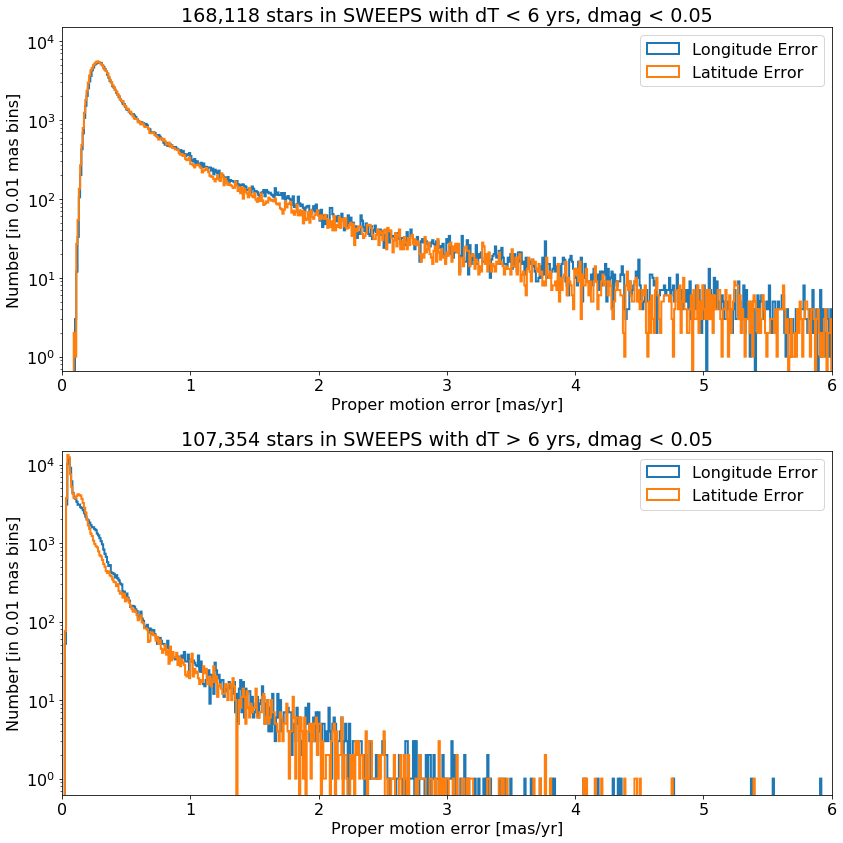

In [9]:
bin = 0.01
hrange = (0,6)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1

tsplit = 6
dmaglim = 0.05

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,12))
pylab.subplot(211)
wmag = np.where((tab['a_f606w_mad']<dmaglim) & (tab['a_f814w_mad']<dmaglim))[0]
w = wmag[tab['dT'][wmag]<=tsplit]
pylab.hist(tab['lpmerr'][w], range=hrange, bins=bincount, label='Longitude Error', 
           histtype='step', linewidth=2)
pylab.hist(tab['bpmerr'][w], range=hrange, bins=bincount, label='Latitude Error', 
           histtype='step', linewidth=2)
pylab.xlabel('Proper motion error [mas/yr]')
pylab.ylabel('Number [in {:0.2} mas bins]'.format(bin))
pylab.legend(loc='upper right')
pylab.yscale('log')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.ylim(0,15000)
pylab.title('{:,} stars in SWEEPS with dT < {} yrs, dmag < {}'.format(len(w),tsplit,dmaglim))
pylab.tight_layout()

pylab.subplot(212)
w = wmag[tab['dT'][wmag]>tsplit]
pylab.hist(tab['lpmerr'][w], range=hrange, bins=bincount, label='Longitude Error', 
           histtype='step', linewidth=2)
pylab.hist(tab['bpmerr'][w], range=hrange, bins=bincount, label='Latitude Error', 
           histtype='step', linewidth=2)
pylab.xlabel('Proper motion error [mas/yr]')
pylab.ylabel('Number [in {:0.2} mas bins]'.format(bin))
pylab.legend(loc='upper right')
pylab.yscale('log')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.ylim(0,15000)
pylab.title('{:,} stars in SWEEPS with dT > {} yrs, dmag < {}'.format(len(w),tsplit,dmaglim))
pylab.tight_layout()

pylab.savefig('{}sweeps_pmerr_loghist2.png'.format(resPath))

# Number of Visits Histogram <a class="anchor" id="visitshist"></a>

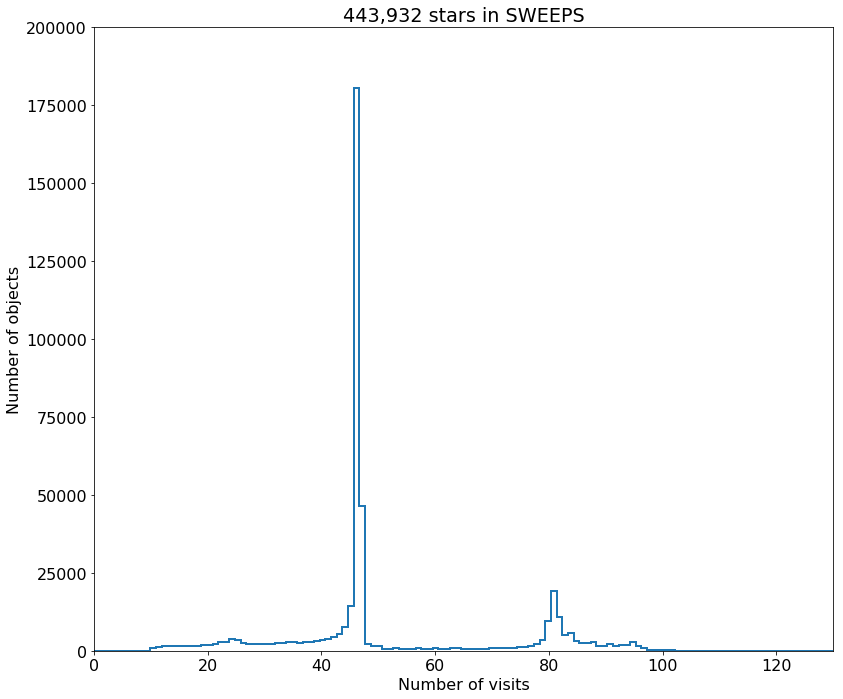

In [10]:
bin = 1
hrange = (0,130)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.hist(tab['NumVisits'], range=hrange, bins=bincount, label='Number of visits ', 
           histtype='step', linewidth=2)
pylab.xlabel('Number of visits')
pylab.ylabel('Number of objects')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.ylim(0,200000)
pylab.title('{:,} stars in SWEEPS'.format(len(tab)))
pylab.tight_layout()
pylab.savefig('{}sweeps_numvisits_hist.png'.format(resPath))

# Time Histograms <a class="anchor" id="timehist"></a>

First plot histogram of observation dates.

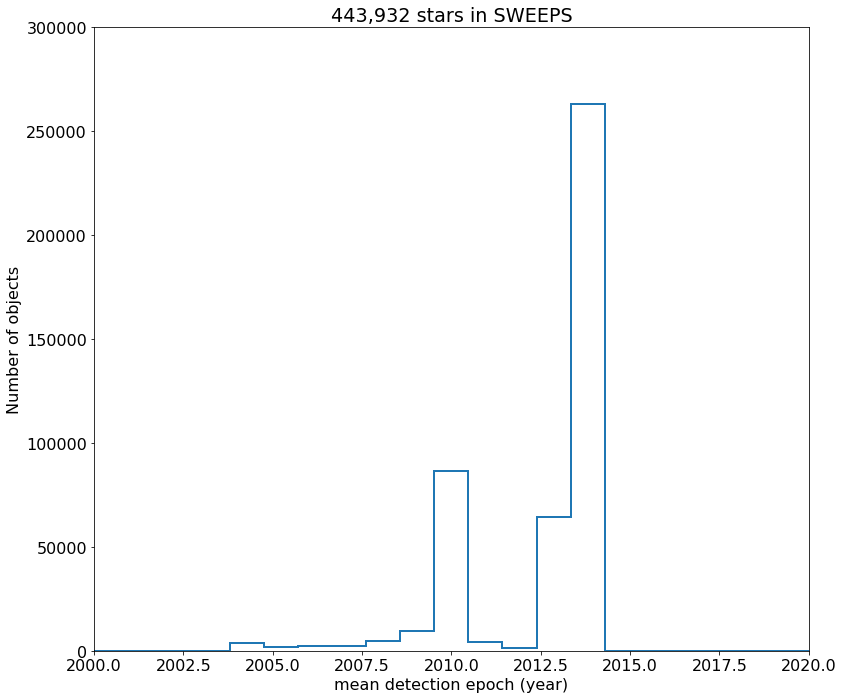

In [11]:
bin = 1
hrange = (2000, 2020)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.hist(tab['yr'], range=hrange, bins=bincount, label='year ', histtype='step', linewidth=2)
pylab.xlabel('mean detection epoch (year)')
pylab.ylabel('Number of objects')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.ylim(0,300000)
pylab.title('{:,} stars in SWEEPS'.format(len(tab)))
pylab.tight_layout()
pylab.savefig('{}sweeps_year_hist.png'.format(resPath))

Then plot histogram of observation duration for the objects.

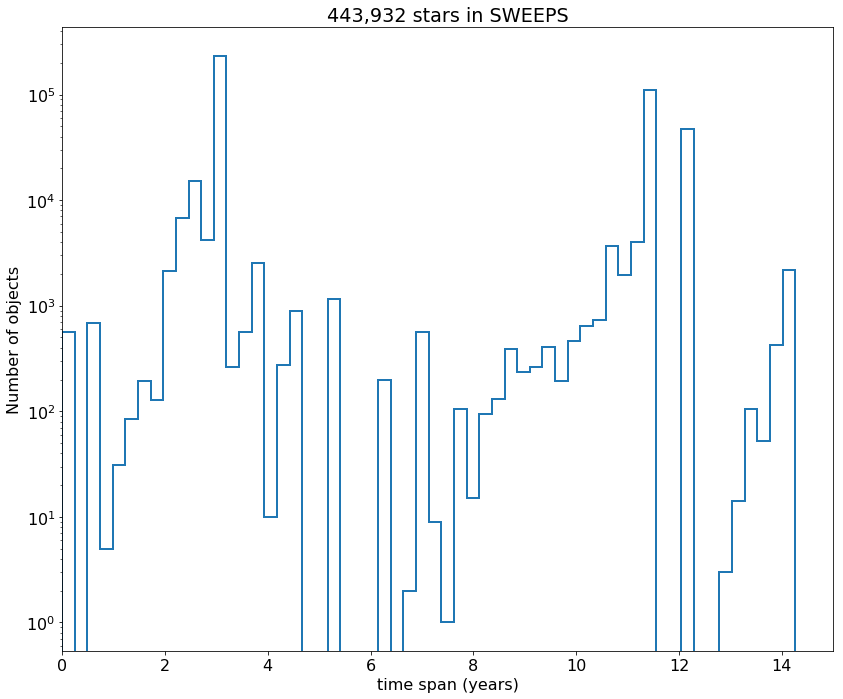

In [12]:
bin = 0.25
hrange = (0, 15)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.hist(tab['dT'], range=hrange, bins=bincount, label='year ', histtype='step', linewidth=2)
pylab.xlabel('time span (years)')
pylab.ylabel('Number of objects')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.yscale('log')
pylab.title('{:,} stars in SWEEPS'.format(len(tab)))
pylab.tight_layout()
pylab.savefig('{}sweeps_year_hist.png'.format(resPath))

# Magnitude Histograms <a class="anchor" id="maghist"></a>

## Aper2 magnitude histograms for F606W and F814W

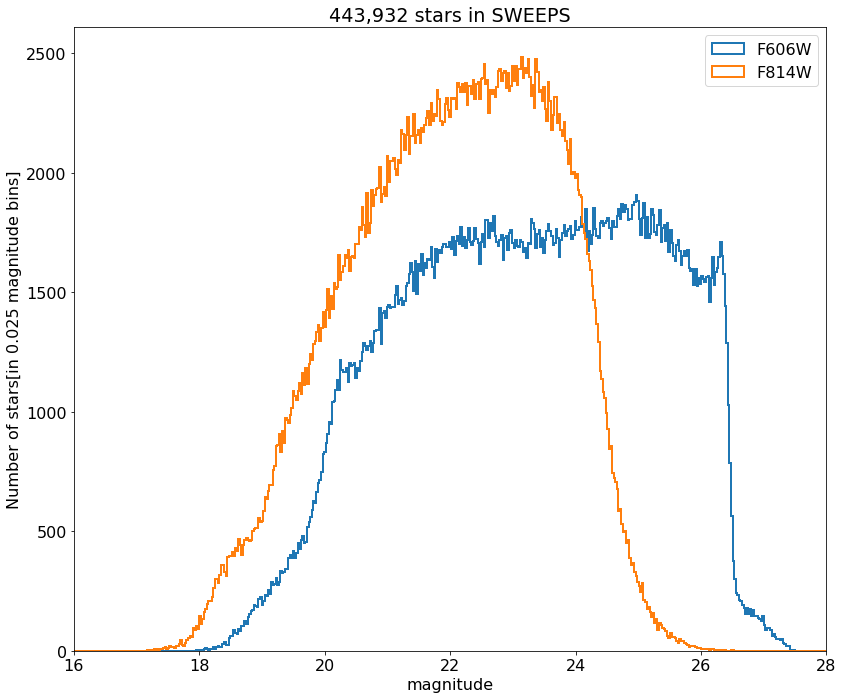

In [13]:
bin = 0.025
hrange = (16,28)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.hist(tab['a_f606w'], range=hrange, bins=bincount, label='F606W', 
           histtype='step',  linewidth=2)
pylab.hist(tab['a_f814w'], range=hrange, bins=bincount, label='F814W', 
           histtype='step', linewidth=2)
pylab.xlabel('magnitude')
pylab.ylabel('Number of stars[in {:0.2} magnitude bins]'.format(bin))
pylab.legend(loc='upper right')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.title('{:,} stars in SWEEPS'.format(len(tab)))
pylab.tight_layout()
pylab.savefig('{}sweeps_mag_hist.png'.format(resPath))

## Aper2 magnitude error histograms for F606W and F814W

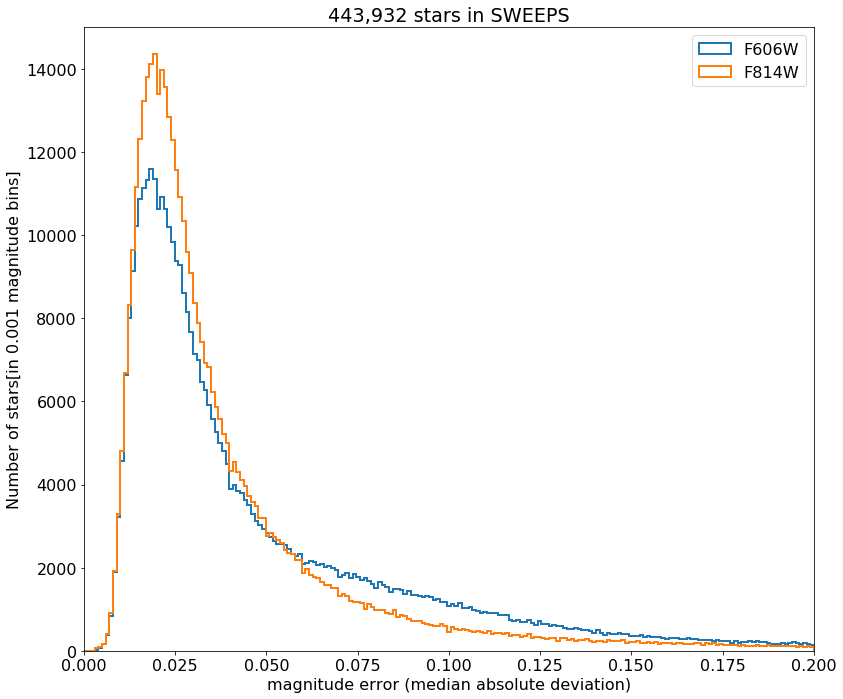

In [14]:
bin = 0.001
hrange = (0,0.2)
bincount = int((hrange[1]-hrange[0])/bin + 0.5) + 1
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.hist(tab['a_f606w_mad'], range=hrange, bins=bincount, label='F606W', 
           histtype='step',  linewidth=2)
pylab.hist(tab['a_f814w_mad'], range=hrange, bins=bincount, label='F814W', 
           histtype='step', linewidth=2)
pylab.xlabel('magnitude error (median absolute deviation)')
pylab.ylabel('Number of stars[in {:0.2} magnitude bins]'.format(bin))
pylab.legend(loc='upper right')
pylab.autoscale(enable=True, axis='x', tight=True)
pylab.ylim(0,15000)
pylab.title('{:,} stars in SWEEPS'.format(len(tab)))
pylab.tight_layout()
pylab.savefig('{}sweeps_magerr_hist.png'.format(resPath))

# Color-Magnitude Diagram <a class="anchor" id="cmdall"></a>

## Color-magnitude diagram

Plot the color-magnitude diagram for the ~440k points retrieved from the database.  This uses fastkde to compute the kernel density estimate for the crowded plot, which is very fast. See https://pypi.org/project/fastkde/ for instructions -- or just do
<br />
<tt>pip install fastkde</tt>

kde took 4.9 sec
Plotting 147664 of 443502 points


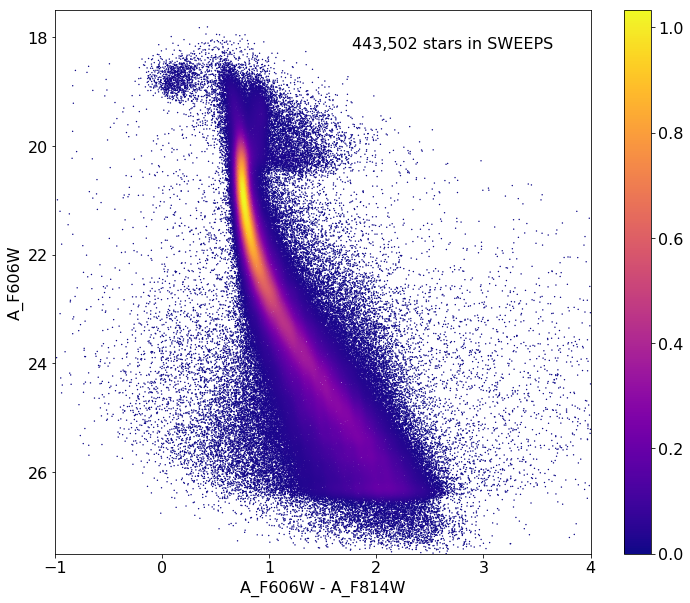

In [15]:
f606w = tab['a_f606w']
f814w = tab['a_f814w']
RminusI = f606w-f814w

# Calculate the point density
w = np.where((RminusI > -1) & (RminusI < 4))[0]
x = np.array(RminusI[w])
y = np.array(f606w[w])
t0 = time.time()
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)
print("kde took {:.1f} sec".format(time.time()-t0))

# interpolate to get z values at points
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.05)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
pylab.autoscale(tight=True)
pylab.xlabel('A_F606W - A_F814W')
pylab.ylabel('A_F606W')
pylab.gca().invert_yaxis()
pylab.xlim(-1,4)
pylab.ylim(27.5,17.5)
pylab.colorbar()
pylab.text(.93,.93,'{:,} stars in SWEEPS'.format(len(x)),
       horizontalalignment='right',
       transform=pylab.gca().transAxes)
pylab.savefig("{}sweeps_colormag1.png".format(resPath))

# Detection Positions <a class="anchor" id="detpos"></a>

Define a function to plot the PM fit for an object.

In [16]:
# define function
def positions(Obj, jobs=None):
    """
    input parameter Obj is the value of the ObjID 
    optional jobs parameter re-uses casjobs jobs variable
    output plots change in (lon, lat) as a function of time
    overplots proper motion fit
    provides number of objects and magnitude/color information
    """
    if not jobs:
        jobs = mastcasjobs.MastCasJobs(context=HSCContext)

    # execute these as "system" queries so they don't fill up your Casjobs history

    # get the measured positions as a function of time
    query = """SELECT dT, dLon, dLat 
        from AstromSourcePositions where ObjID={}
        order by dT
        """.format(Obj)
    pos = jobs.quick(query, context=HSCContext, task_name="SWEEPS/Microlensing",
                     astropy=True, system=True)
    
    # get the PM fit parameters
    query = """SELECT pmlon, pmlonerr, pmlat, pmlaterr
        from AstromProperMotions where ObjID={}
        """.format(Obj)
    pm = jobs.quick(query, context=HSCContext, task_name="SWEEPS/Microlensing",
                    astropy=True, system=True)
    
    lpm = pm['pmlon'][0]
    bpm = pm['pmlat'][0]
    
    # get the intercept for the proper motion fit referenced to the start time
    # time between mean epoch and zero (ref) epoch (years)

    # get median magnitudes and colors for labeling
    query = """SELECT a_f606w=i1.MagMed, a_f606_m_f814w=i1.MagMed-i2.MagMed
        from AstromSumMagAper2 i1 
        join AstromSumMagAper2 i2 on i1.ObjID=i2.ObjID 
        where i1.ObjID={} and i1.filter='f606w' and i2.filter='f814w' 
        """.format(Obj)
    phot = jobs.quick(query, context=HSCContext, task_name="SWEEPS/Microlensing",
                      astropy=True, system=True)
    f606w = phot['a_f606w'][0]
    f606wmf814w = phot['a_f606_m_f814w'][0]

    x = pos['dT']
    y = pos['dLon']
    pylab.rcParams.update({'font.size':10})
    pylab.figure(1,(6,3))
    pylab.subplot(121)
    pylab.scatter(x, y, s=10)
    # xpm = np.linspace(0, max(x), 10)
    xpm = np.array([x.min(),x.max()])
    ypm = lpm*xpm
    pylab.plot(xpm, ypm, '-r')
    pylab.xlabel('dT (yrs)')
    pylab.ylabel('dLon (mas)')
    y = pos['dLat']
    pylab.subplot(122)
    pylab.scatter(x, y, s=10)
    ypm = bpm*xpm
    pylab.plot(xpm, ypm, '-r')
    pylab.xlabel('dT (yrs)')
    pylab.ylabel('dLat (mas)')
    pylab.suptitle("""ObjID {0}
{1} detections,  (lpm, bpm) = ({2:.1f}, {3:.1f}) mas/yr
(f606w, f606w-f814w) = ({4:.1f}, {5:.1f})""".format(Obj, len(x), lpm, bpm, f606w, f606wmf814w),
                  size=10)
    pylab.tight_layout(rect=[0, 0.0, 1, 0.88])
    pylab.show()
    pylab.close()

## Plot positions of objects that are detected in more than 90 visits with a median absolute deviation from the fit of less than 1.5 mas and proper motion error less than 1.0 mas/yr.

Plotting 21 objects


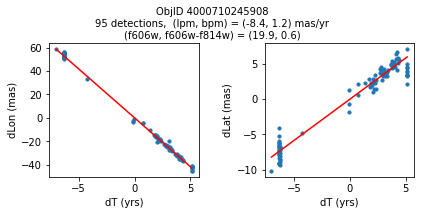

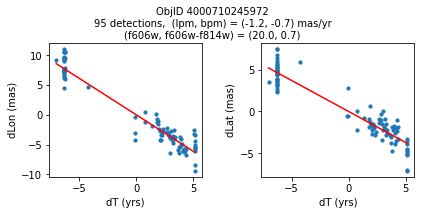

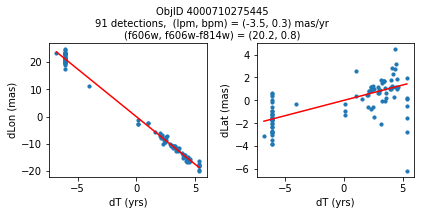

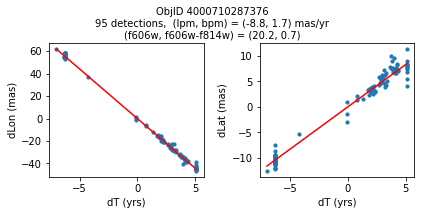

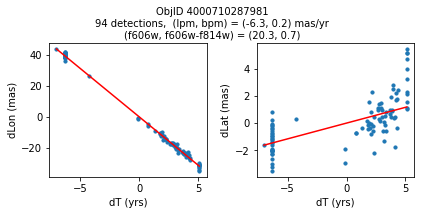

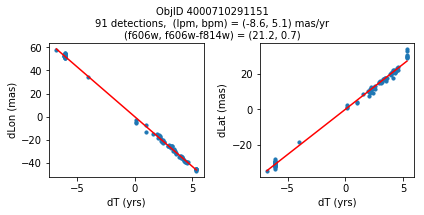

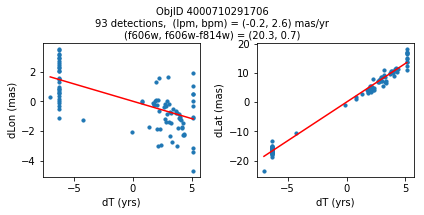

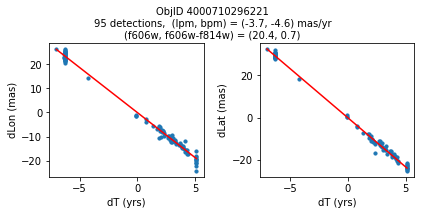

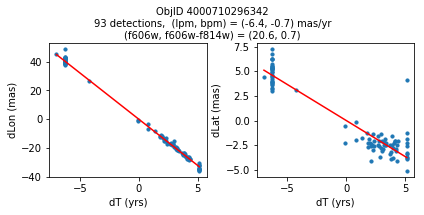

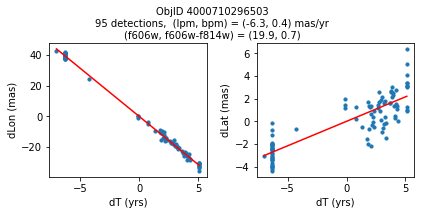

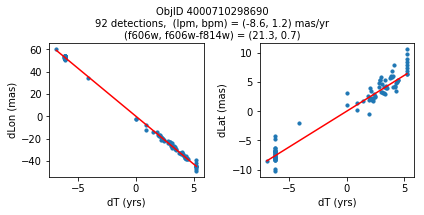

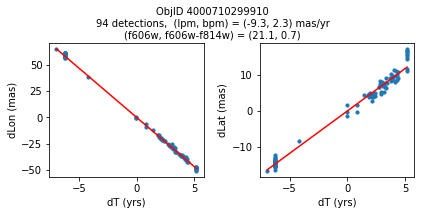

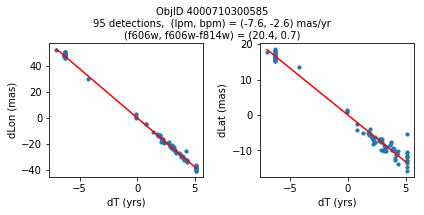

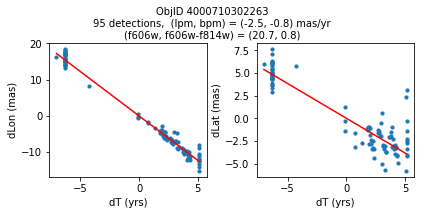

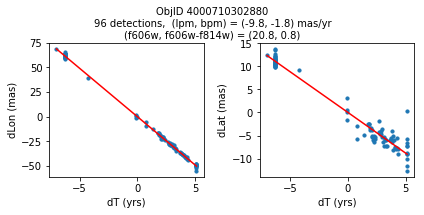

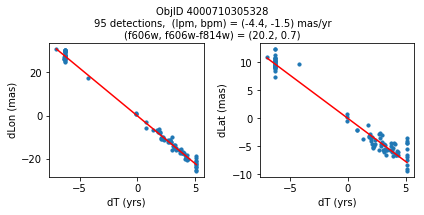

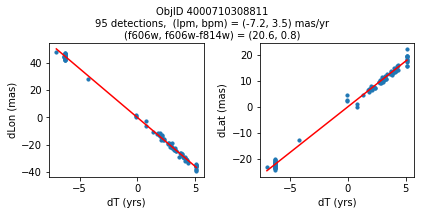

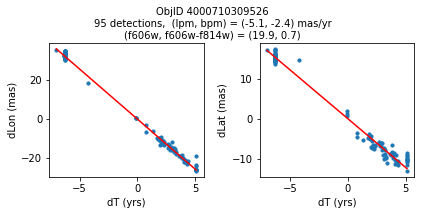

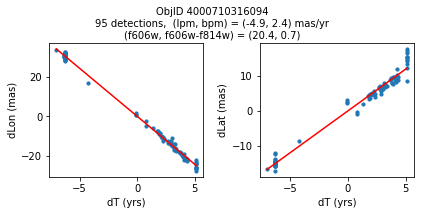

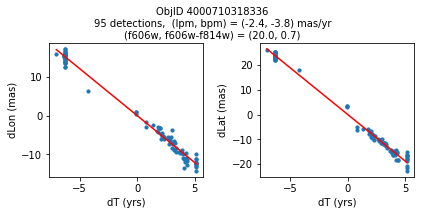

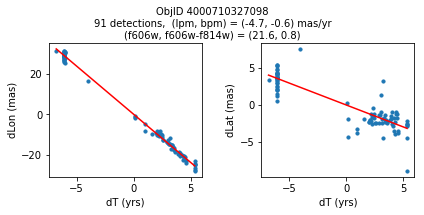

In [17]:
n = tab['NumVisits']
dev = tab['pmdev']
objid = tab['ObjID']
lpmerr0 = np.array(tab['lpmerr'])
bpmerr0 = np.array(tab['bpmerr'])
wi = np.where( (dev < 1.5) & (n > 90) & (np.sqrt(bpmerr0**2+lpmerr0**2) < 1.0))[0]
print("Plotting {} objects".format(len(wi)))
for o in objid[wi]:
    positions(o, jobs=jobs)

# Good Photometric Objects <a class="anchor" id="goodphot"></a>

## Look at photometric error distribution to pick out good photometry objects as a function of magnitude <a class="anchor" id="gooderrs"></a>

The photometric error is mainly a function of magnitude.  We make a cut slightly above the typical error to exclude objects that have poor photometry.  (In the SWEEPS field, that most often is the result of blending and crowding.)

Plotting 274417 of 443502 points
10.5 s: completed kde
Plotting 250469 of 443502 points


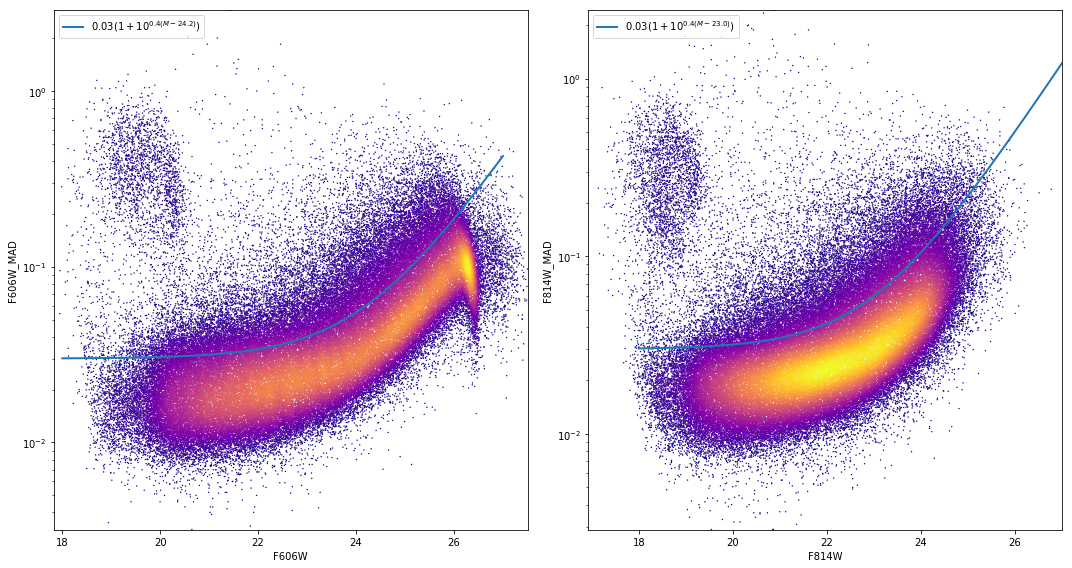

In [18]:
f606w = tab['a_f606w']
f814w = tab['a_f814w']
RminusI = f606w-f814w

w = np.where((RminusI > -1) & (RminusI < 4))[0]
f606w_mad = tab['a_f606w_mad']
f814w_mad = tab['a_f814w_mad']

t0=time.time()
# Calculate the point density
x1 = np.array(f606w[w])
y1 = np.array(f606w_mad[w])
y1log = np.log(y1)
myPDF1,axes1 = fastKDE.pdf(x1,y1log,numPoints=2**10+1)
finterp = RectBivariateSpline(axes1[1],axes1[0],myPDF1)
z1 = finterp(y1log,x1,grid=False)
# Sort the points by density, so that the densest points are plotted last
idx = z1.argsort()
xs1, ys1, zs1 = x1[idx], y1[idx], z1[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs1))*zs1<0.05)[0]
print("Plotting {} of {} points".format(len(wran),len(zs1)))
xs1 = xs1[wran]
ys1 = ys1[wran]
zs1 = zs1[wran]

x2 = np.array(f814w[w])
y2 = np.array(f814w_mad[w])
y2log = np.log(y2)
myPDF2,axes2 = fastKDE.pdf(x2,y2log,numPoints=2**10+1)
finterp = RectBivariateSpline(axes2[1],axes2[0],myPDF2)
z2 = finterp(y2log,x2,grid=False)
idx = z2.argsort()
xs2, ys2, zs2 = x2[idx], y2[idx], z2[idx]
print("{:.1f} s: completed kde".format(time.time()-t0))

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs2))*zs2<0.05)[0]
print("Plotting {} of {} points".format(len(wran),len(zs2)))
xs2 = xs2[wran]
ys2 = ys2[wran]
zs2 = zs2[wran]

xr = (18,27)
xx = np.arange(501)*(xr[1]-xr[0])/500.0 + xr[0]
xcut1 = 24.2
xnorm1 = 0.03
xcut2 = 23.0
xnorm2 = 0.03

# only plot a subset of the points to speed things up
qsel = 3
xs1 = xs1[::qsel]
ys1 = ys1[::qsel]
zs1 = zs1[::qsel]
xs2 = xs2[::qsel]
ys2 = ys2[::qsel]
zs2 = zs2[::qsel]

pylab.figure(1,(15,8))
pylab.subplot(121)
pylab.yscale('log')
pylab.scatter(xs1,ys1,c=zs1,s=2,edgecolor='',cmap='plasma')
pylab.autoscale(tight=True)
# overplot an error limit that varies with magnitude of the form listed below
pylab.plot(xx,xnorm1 * (1. + 10.**(0.4*(xx-xcut1))),linewidth=2.0,
           label='$%.2f (1+10^{0.4(M-%.1f)})$' % (xnorm1,xcut1))
pylab.legend(loc='upper left')
pylab.xlabel('F606W')
pylab.ylabel('F606W_MAD')

pylab.subplot(122)
pylab.yscale('log')
pylab.scatter(xs2,ys2,c=zs2,s=2,edgecolor='',cmap='plasma')
pylab.autoscale(tight=True)
# overplot an error limit that varies with magnitude of the form listed below
pylab.plot(xx,xnorm2 * (1. + 10.**(0.4*(xx-xcut2))),linewidth=2.0,
           label='$%.2f (1+10^{0.4(M-%.1f)})$' % (xnorm2,xcut2))
pylab.legend(loc='upper left')
pylab.xlabel('F814W')
pylab.ylabel('F814W_MAD')
pylab.tight_layout()

## Define function to apply noise cut and plot color-magnitude diagram with cut
Note that we reduce the R-I range to 0-3 here because there are very few objects left bluer than R-I = 0 or redder than R-I = 3.

kde took 4.2 sec
Plotting 129279 of 333525 points


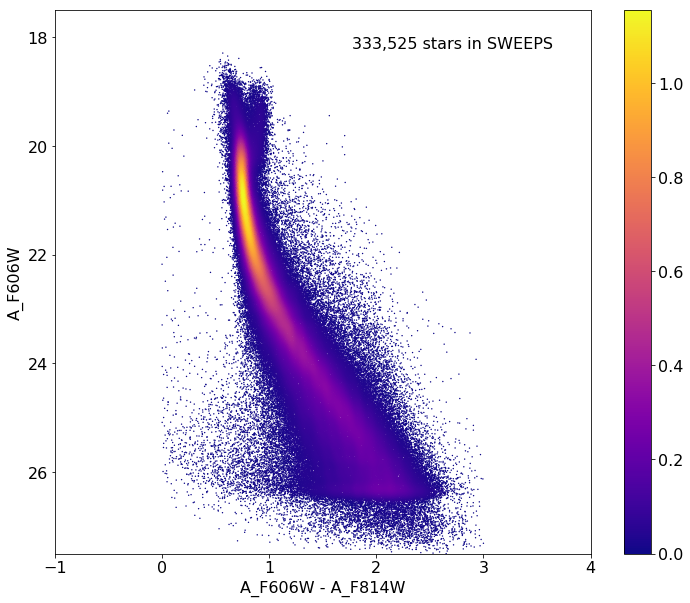

In [19]:
def noisecut(tab, factor=1.0):
    """Return boolean array with noise cut in f606w and f814w using model
    factor is normalization factor to use (>1 means allow more noise)
    """
    f606w = tab['a_f606w']
    f814w = tab['a_f814w']
    f606w_mad = tab['a_f606w_mad']
    f814w_mad = tab['a_f814w_mad']
    
    # noise model computed above
    xcut_f606w = 24.2
    xnorm_f606w = 0.03 * factor
    xcut_f814w = 23.0
    xnorm_f814w = 0.03 * factor
    return ((f606w_mad < xnorm_f606w*(1+10.0**(0.4*(f606w-xcut_f606w))))
          & (f814w_mad < xnorm_f814w*(1+10.0**(0.4*(f814w-xcut_f814w))))
           )

# low-noise objects
good = noisecut(tab,factor=1.0)

# Calculate the point density
w = np.where((RminusI > 0) & (RminusI < 3) & good)[0]
x = np.array(RminusI[w])
y = np.array(f606w[w])
t0 = time.time()
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)
print("kde took {:.1f} sec".format(time.time()-t0))

# interpolate to get z values at points
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.075)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
pylab.xlabel('A_F606W - A_F814W')
pylab.ylabel('A_F606W')
pylab.gca().invert_yaxis()
pylab.xlim(-1,4)
pylab.ylim(27.5,17.5)
pylab.colorbar()
pylab.text(.93,.93,'{:,} stars in SWEEPS'.format(len(x)),
       horizontalalignment='right',
       transform=pylab.gca().transAxes)
pylab.savefig("{}sweeps_colormag2.png".format(resPath))

# Science Applications <a class="anchor" id="sciap"></a>

# Proper Motions of Good Objects <a class="anchor" id="goodpm"></a>

## Average proper motion in color-magnitude bins 

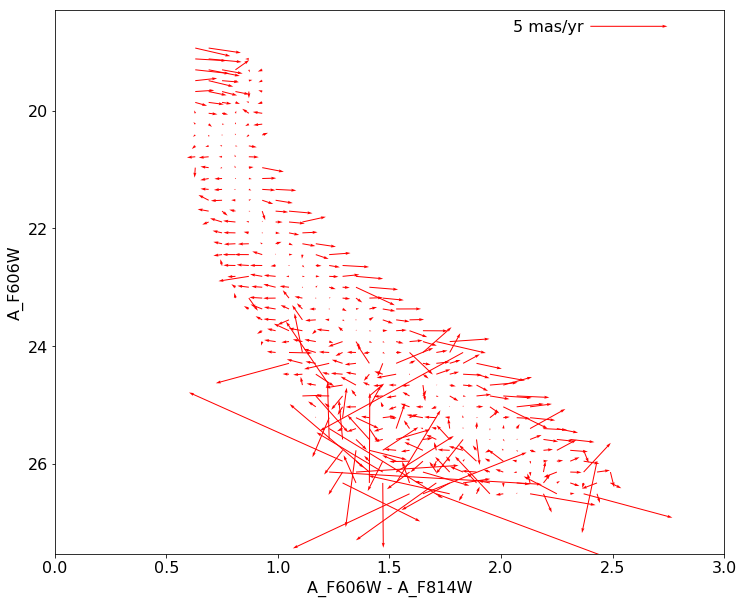

In [20]:
# good defined above
f606w = tab['a_f606w']
f814w = tab['a_f814w']
RminusI = f606w-f814w
w = np.where((RminusI > 0) & (RminusI < 3) & good)[0]
lpm = np.array(tab['lpm'][w])
bpm = np.array(tab['bpm'][w])
x = np.array(RminusI[w])
y = np.array(f606w[w])

nbins = 50
count2d, yedge, xedge = np.histogram2d(y, x, bins=nbins)
lpm_sum = np.histogram2d(y, x, bins=nbins, weights=lpm-lpm.mean())[0]
bpm_sum = np.histogram2d(y, x, bins=nbins, weights=bpm-bpm.mean())[0]
lpm_sumsq = np.histogram2d(y, x, bins=nbins, weights=(lpm-lpm.mean())**2)[0]
bpm_sumsq = np.histogram2d(y, x, bins=nbins, weights=(bpm-bpm.mean())**2)[0]

ccount = count2d.clip(1) 
lpm_mean = lpm_sum/ccount
bpm_mean = bpm_sum/ccount
lpm_rms = np.sqrt(lpm_sumsq/ccount-lpm_mean**2)
bpm_rms = np.sqrt(bpm_sumsq/ccount-bpm_mean**2)
lpm_msigma = lpm_rms/np.sqrt(ccount)
bpm_msigma = bpm_rms/np.sqrt(ccount)

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
ww = np.where(count2d > 100)
yy, xx = np.mgrid[:nbins,:nbins]
xx = (0.5*(xedge[1:]+xedge[:-1]))[xx]
yy = (0.5*(yedge[1:]+yedge[:-1]))[yy]
# pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
Q = pylab.quiver(xx[ww],yy[ww],lpm_mean[ww],bpm_mean[ww],color='red',width=0.0015)
qlength = 5
pylab.quiverkey(Q,0.8,0.97,qlength,'{} mas/yr'.format(qlength),coordinates='axes',labelpos='W')
pylab.gca().invert_yaxis()
pylab.autoscale(tight=True)
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[-1],yedge[0]))
pylab.xlabel('A_F606W - A_F814W')
pylab.ylabel('A_F606W')
pylab.savefig('{}sweeps_vecmean.png'.format(resPath))

## RMS in longitude PM as a function of color/magnitude

# Mean longitude PM as image

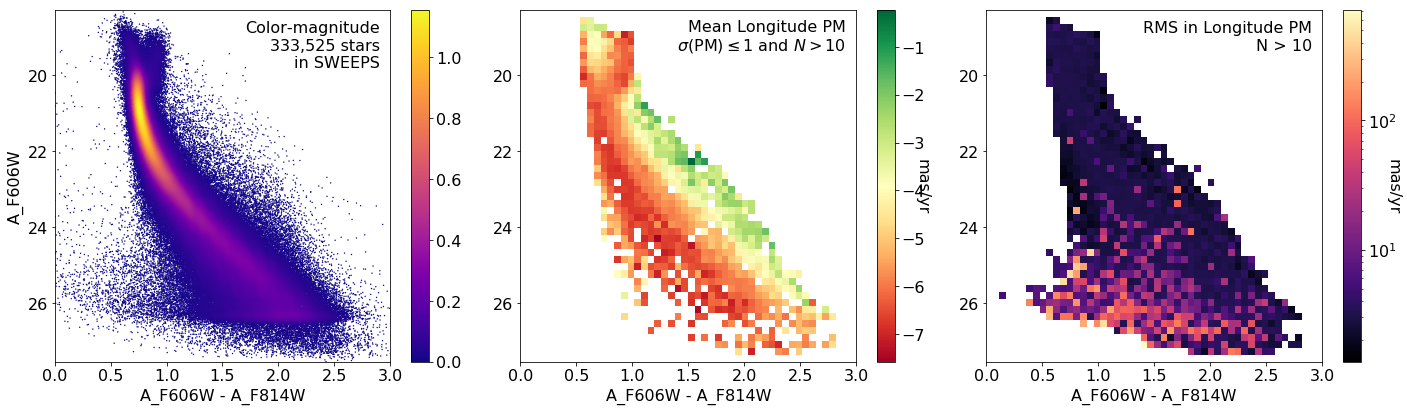

In [21]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(20,6))

sub1 = pylab.subplot(131)
pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
pylab.gca().invert_yaxis()
pylab.xlabel('A_F606W - A_F814W')
pylab.ylabel('A_F606W')
pylab.text(0.97, 0.97,
       'Color-magnitude\n{:,} stars\nin SWEEPS'.format(len(x)),
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
pylab.colorbar()

sub2 = pylab.subplot(132)
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
mask = (lpm_msigma <= 1.0) & (count2d > 10)
im = (lpm_mean+lpm.mean())*mask
im[~mask] = np.nan
vmax = np.nanmax(np.abs(im))
pylab.imshow(im,cmap='RdYlGn',aspect="auto",origin="lower",
            extent=(xedge[0],xedge[-1],yedge[0],yedge[-1]))
pylab.gca().invert_yaxis()
pylab.xlabel('A_F606W - A_F814W')
pylab.text(0.97, 0.97,'Mean Longitude PM\n$\sigma(\mathrm{PM}) \leq 1$ and $N > 10$',
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
cbar = pylab.colorbar()
cbar.ax.set_ylabel('mas/yr', rotation=270)

sub2 = pylab.subplot(133)
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
im = lpm_rms*(count2d>10)
pylab.imshow(im,cmap='magma',aspect="auto",origin="lower",
            extent=(xedge[0],xedge[-1],yedge[0],yedge[-1]),
            norm=LogNorm(vmin=im[im>0].min(), vmax=im.max()))
pylab.gca().invert_yaxis()
pylab.xlabel('A_F606W - A_F814W')
pylab.text(0.97, 0.97,'RMS in Longitude PM\nN > 10',
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
cbar = pylab.colorbar()
cbar.ax.set_ylabel('mas/yr', rotation=270)

pylab.tight_layout()
pylab.savefig("{}sweeps_PMlon.png".format(resPath))

## Mean latitude PM as image

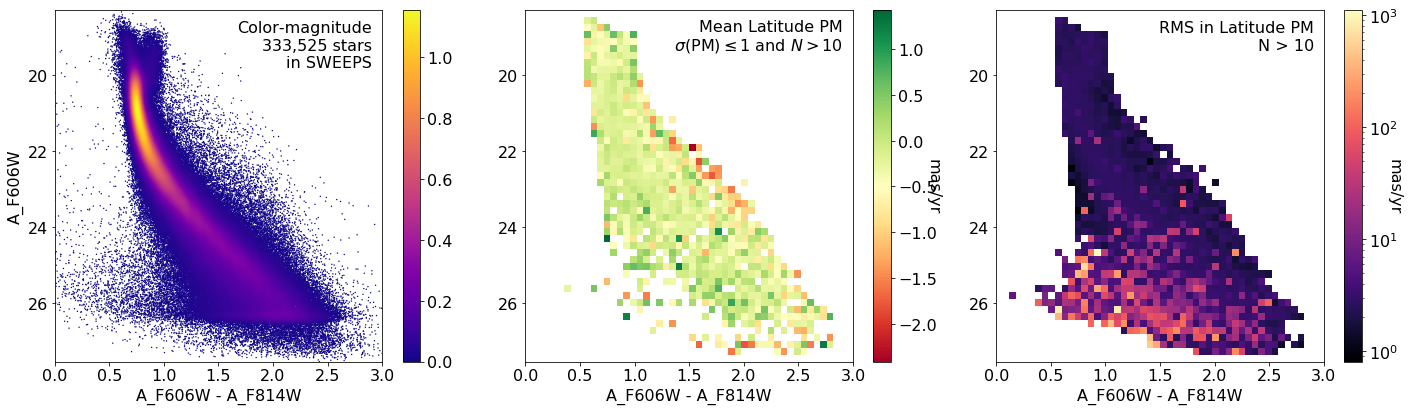

In [22]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(20,6))

sub1 = pylab.subplot(131)
pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
pylab.gca().invert_yaxis()
pylab.xlabel('A_F606W - A_F814W')
pylab.ylabel('A_F606W')
pylab.text(0.97,0.97,
       'Color-magnitude\n{:,} stars\nin SWEEPS'.format(len(x)),
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
pylab.colorbar()

sub2 = pylab.subplot(132)
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
mask = (bpm_msigma <= 1.0) & (count2d > 10)
im = (bpm_mean+bpm.mean())*mask
im[~mask] = np.nan
vmax = np.nanmax(np.abs(im))
pylab.imshow(im,cmap='RdYlGn',aspect="auto",origin="lower",
            extent=(xedge[0],xedge[-1],yedge[0],yedge[-1]))
pylab.gca().invert_yaxis()
pylab.xlabel('A_F606W - A_F814W')
pylab.text(.97,.97,'Mean Latitude PM\n$\sigma(\mathrm{PM}) \leq 1$ and $N > 10$',
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
cbar = pylab.colorbar()
cbar.ax.set_ylabel('mas/yr', rotation=270)

sub2 = pylab.subplot(133)
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
im = bpm_rms*(count2d>10)
pylab.imshow(im,cmap='magma',aspect="auto",origin="lower",
            extent=(xedge[0],xedge[-1],yedge[0],yedge[-1]),
            norm=LogNorm(vmin=im[im>0].min(), vmax=im.max()))
pylab.gca().invert_yaxis()
pylab.xlabel('A_F606W - A_F814W')
pylab.text(.97,.97,'RMS in Latitude PM\nN > 10',
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
cbar = pylab.colorbar()
cbar.ax.set_ylabel('mas/yr', rotation=270)

pylab.tight_layout()
pylab.savefig("{}sweeps_PMlat.png".format(resPath))

# Proper Motions in Bulge and Disk <a class="anchor" id="bulgedisk"></a>

## Fit a smooth function to the main ridgeline of color-magnitude diagram
Fit the R-I vs R values, but force the function to increase montonically with R.  We use a log transform of the y coordinate to help.

In [23]:
# locate ridge line
iridgex = np.argmax(myPDF,axis=1)
pdfx = myPDF[np.arange(len(iridgex),dtype=int),iridgex]
# pdfx = myPDF.max(axis=1)
wx = np.where(pdfx > 0.1)[0]
iridgex = iridgex[wx]
# use weighted sum of 2*hw+1 points around peak
hw = 10
pridgex = 0.0
pdenom = 0.0
for k in range(-hw,hw+1):
    wt = myPDF[wx,iridgex+k]
    pridgex = pridgex + k*wt
    pdenom = pdenom + wt
pridgex = iridgex + pridgex/pdenom
ridgex = np.interp(pridgex, np.arange(len(axes[0])), axes[0])

# Fit the data using a polynomial model
x0 = axes[1][wx].min()
x1 = axes[1][wx].max()
p_init = models.Polynomial1D(9)
fit_p = fitting.LinearLSQFitter()
xx = (axes[1][wx]-x0)/(x1-x0)
yoff = 0.65
yy = np.log(ridgex - yoff)
p = fit_p(p_init, xx, yy)

# define useful functions for the ridge line

def ridge_color(f606w, function=p, yoff=yoff, x0=x0, x1=x1):
    """Return R-I position of ridge line as a function of f606w magnitude
    
    function, yoff, x0, x1 are from polynomial fit above
    """
    return yoff + np.exp(p((f606w-x0)/(x1-x0)))

# calculate grid of function values for approximate inversion
rxgrid = axes[1][wx]
rygrid = ridge_color(rxgrid)
color_domain = [rygrid[0],rygrid[-1]]
mag_domain = [axes[1][wx[0]], axes[1][wx[-1]]]
print("color_domain {}".format(color_domain))
print("mag_domain   {}".format(mag_domain))

def ridge_mag(RminusI, xgrid=rxgrid, ygrid=rygrid):
    """Return f606w position of ridge line as a function of R-I color
    
    Uses simple linear interpolation to get approximate value
    """
    f606w = np.interp(RminusI,ygrid,xgrid)
    f606w[(RminusI < ygrid[0]) | (RminusI > ygrid[-1])] = np.nan
    return f606w

color_domain [0.6883374859500192, 2.1560516758237167]
mag_domain   [19.356585323810577, 26.480549454689026]


Plot the results to check that they look reasonable.

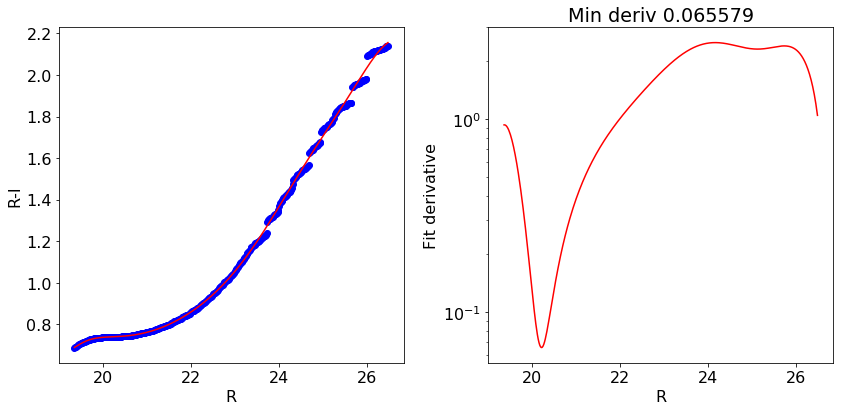

In [24]:
ridgexf = yoff + np.exp(p(xx))

pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.plot(axes[1][wx], ridgex, 'bo')
pylab.plot(axes[1][wx], ridgexf, color='red')
pylab.ylabel('R-I')
pylab.xlabel('R')

# check the derivative plot to see if it stays positive
deriv = np.exp(p(xx))*models.Polynomial1D.horner(xx, 
                            (p.parameters * np.arange(len(p.parameters)))[1:])
pylab.subplot(122)
pylab.semilogy(axes[1][wx], np.exp(p(xx))*models.Polynomial1D.horner(xx, 
                            (p.parameters * np.arange(len(p.parameters)))[1:]),color='red')
pylab.xlabel('R')
pylab.ylabel('Fit derivative')
pylab.title('Min deriv {:.6f}'.format(deriv.min()))
pylab.tight_layout()

## Plot the ridgeline on the CMD

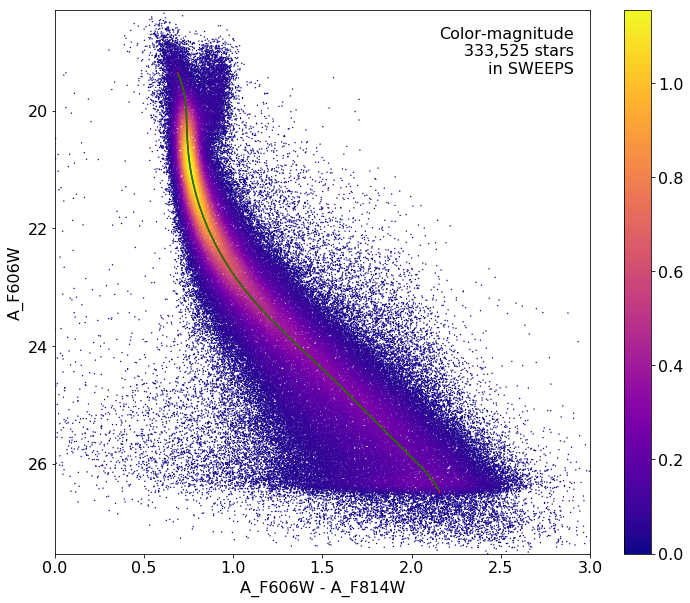

In [25]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
pylab.gca().invert_yaxis()

# overplot ridge line
pylab.plot(ridge_color(axes[1][wx]), axes[1][wx], color='red')
pylab.plot(axes[0], ridge_mag(axes[0]), color='green')

pylab.xlabel('A_F606W - A_F814W')
pylab.ylabel('A_F606W')
pylab.text(.97,.97,
       'Color-magnitude\n{:,} stars\nin SWEEPS'.format(len(x)),
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
pylab.colorbar()
# pylab.savefig('{}sweeps_ridgeline.png'.format(resPath))

## Binned distribution of PM(Long) vs magnitude offset from ridge line

1.0020693112164736 23.7849690241099 1.0020693112164736 20.7849690241099
(394,) (394,)


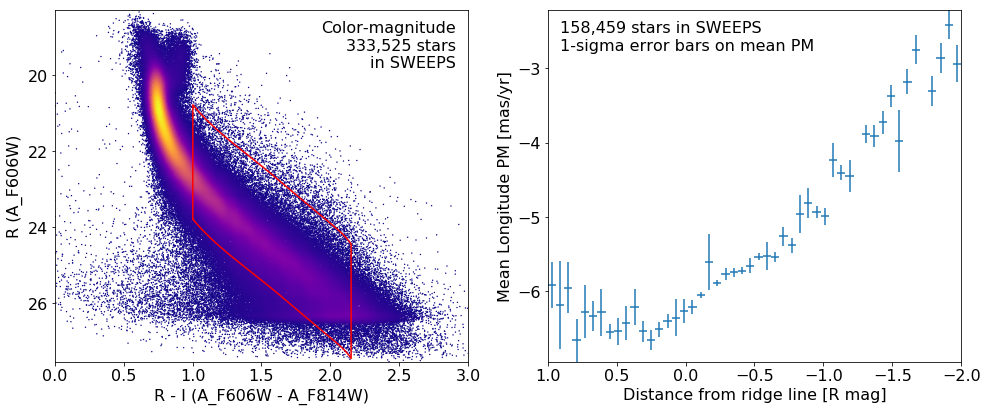

In [26]:
yloc = ridge_mag(x)
x1 = x[np.isfinite(yloc)]
wy = np.where((axes[0] >= x1.min()) & (axes[0] <= x1.max()))[0]
ridgey = ridge_mag(axes[0][wy])

# Weighted histogram
dmagmin = -2.0
dmagmax = 1.0
xmax = axes[0][wy[-1]]
# xmin = axes[0][wy[0]]
xmin = 1.0
wsel = np.where((y-yloc >= dmagmin) & (y-yloc <= dmagmax) & (x >= xmin) & (x <= xmax))[0]

x2 = y[wsel]-yloc[wsel]
y2 = lpm[wsel]-lpm.mean()
hrange = (dmagmin, dmagmax)
hbins = 50
count1d, xedge1d = np.histogram(x2,range=hrange,bins=hbins)
lpm_sum1d = np.histogram(x2,range=hrange,bins=hbins,weights=y2)[0]
lpm_sumsq1d = np.histogram(x2,range=hrange,bins=hbins,weights=y2**2)[0]

ccount1d = count1d.clip(1)
lpm_mean1d = lpm_sum1d/ccount1d
lpm_rms1d = np.sqrt(lpm_sumsq1d/ccount1d-lpm_mean1d**2)
lpm_msigma1d = lpm_rms1d/np.sqrt(ccount1d)
lpm_mean1d += lpm.mean()

x1d = 0.5*(xedge1d[1:]+xedge1d[:-1])

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(14,6))

sub1 = pylab.subplot(121)
pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
pylab.gca().invert_yaxis()
pylab.xlabel('R - I (A_F606W - A_F814W)')
pylab.ylabel('R (A_F606W)')
pylab.text(.97,.97,
       'Color-magnitude\n{:,} stars\nin SWEEPS'.format(len(x)),
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
xboundary = np.hstack((axes[0][wy],axes[0][wy[::-1]]))
yboundary = np.hstack((ridgey+dmagmax,ridgey[::-1]+dmagmin))
wb = np.where((xboundary >= xmin) & (xboundary <= xmax))
xboundary = xboundary[wb]
yboundary = yboundary[wb]
print(xboundary[0],yboundary[0],xboundary[-1],yboundary[-1])
print(xboundary.shape,yboundary.shape)
xboundary = np.append(xboundary,xboundary[0])
yboundary = np.append(yboundary,yboundary[0])
pylab.plot(xboundary, yboundary, color='red')

sub1 = pylab.subplot(122)
# don't plot huge error points
wp = np.where(lpm_msigma1d < 1)
pylab.errorbar(x1d[wp], lpm_mean1d[wp], xerr=(xedge1d[1]-xedge1d[0])/2.0, 
               yerr=lpm_msigma1d[wp], linestyle='')
pylab.autoscale(tight=True)
pylab.xlabel('Distance from ridge line [R mag]')
pylab.ylabel('Mean Longitude PM [mas/yr]')
pylab.gca().invert_xaxis()
pylab.text(.03,.97,'{:,} stars in SWEEPS\n1-sigma error bars on mean PM'.format(len(x2)),
       horizontalalignment='left', verticalalignment='top',
       transform=pylab.gca().transAxes)
pylab.tight_layout()

## Reproduce Figure 1 from  <a href="https://ui.adsabs.harvard.edu/abs/2014ApJ...790..164C">Calamida et al. 2014</a>

<img src="http://iopscience.iop.org/0004-637X/790/2/164/downloadFigure/figure/apj498303f1" />

Plotting 156263 of 333525 points
Selected 333,525 low-noise objects
Selected 2,797 red objects
Initially selected 59,605 MS objects
Selected 2,797 MS objects closest to ridge


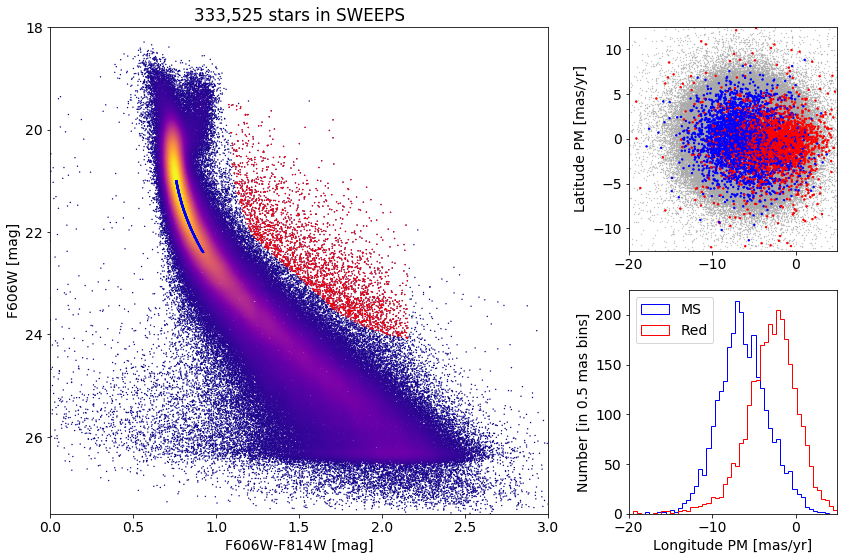

In [27]:
w = np.where((RminusI > 0) & (RminusI < 3) & good)[0]

# Calculate the point density
x = np.array(RminusI[w])
y = np.array(f606w[w])
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.1)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

# locate ridge line in magnitude as a function of color
xloc = ridge_color(y)
ridgex = ridge_color(axes[1][wx])

# locate ridge line in color as function of magnitude
yloc = ridge_mag(x)
x1 = x[np.isfinite(yloc)]
wy = np.where((axes[0] >= x1.min()) & (axes[0] <= x1.max()))[0]
ridgey = ridge_mag(axes[0][wy])

# low-noise objects
print("Selected {:,} low-noise objects".format(len(w)))

# red objects
ylim = yloc - 1.5 - (yloc - 25.0).clip(0)/(1+10.0**(-0.4*(yloc-26.0)))
wred = np.where((y<25) & (y > 19.5) & (y < ylim) & (x-xloc > 0.35))[0]
#wred = np.where((y<25) & (y > 19.5) & ((y-yloc) < -1.5)
#                   & (x-xloc > 0.3))[0]
#                   & (x > 1.1) & (x < 2.5) & (x-xloc > 0.2))[0]
print("Selected {:,} red objects".format(len(wred)))
# main sequence objects
wmain = np.where((y>21) & (y<22.4) & (np.abs(x-xloc) < 0.1))[0]
print("Initially selected {:,} MS objects".format(len(wmain)))
# sort by distance from ridge and select the closest
wmain = wmain[np.argsort(np.abs(x[wmain]-xloc[wmain]))]
wmain = wmain[:len(wred)]
print("Selected {:,} MS objects closest to ridge".format(len(wmain)))

pylab.rcParams.update({'font.size': 14})

pylab.figure(1,(12,8))
pylab.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
pylab.scatter(xs,ys,c=zs,s=2,cmap='plasma',edgecolor='')
pylab.scatter(x[wred],y[wred],c='red',s=2,edgecolor='')
pylab.scatter(x[wmain],y[wmain],c='blue',s=2,edgecolor='')
pylab.xlim(0,3)
pylab.ylim(18,27.5)
pylab.xlabel('F606W-F814W [mag]')
pylab.ylabel('F606W [mag]')
pylab.gca().invert_yaxis()
pylab.title('{:,} stars in SWEEPS'.format(len(x)))

lrange = (-20,5)
brange = (-12.5,12.5)

# plot MS and red points in random order
wsel = w[np.append(wmain,wred)]
colors = np.array(['blue']*len(wsel))
colors[len(wmain):] = 'red'
irs = np.argsort(np.random.random(len(wsel)))
wsel = wsel[irs]
colors = colors[irs]

pylab.subplot2grid((2,3), (0,2), rowspan=1, colspan=1)
pylab.scatter(tab['lpm'][w],tab['bpm'][w],c='darkgray',s=0.1)
pylab.scatter(tab['lpm'][wsel],tab['bpm'][wsel],c=colors,s=2)
pylab.xlim(*lrange)
pylab.ylim(*brange)
pylab.ylabel('Latitude PM [mas/yr]')

pylab.subplot2grid((2,3), (1,2), rowspan=1, colspan=1)
bin = 0.5
bincount = int((lrange[1]-lrange[0])/bin + 0.5) + 1
pylab.hist(tab['lpm'][w[wmain]], range=lrange, bins=bincount, label='MS', color='blue', 
           histtype='step')
pylab.hist(tab['lpm'][w[wred]], range=lrange, bins=bincount, label='Red', color='red', 
           histtype='step')
pylab.xlim(*lrange)
pylab.xlabel('Longitude PM [mas/yr]')
pylab.ylabel('Number [in {:.2} mas bins]'.format(bin))
pylab.legend(loc='upper left')
pylab.tight_layout()
pylab.savefig('{}sweeps_calamida.png'.format(resPath))

# Mean and median proper motions of bulge stars compared with SgrA* (-6.379 $\pm$ 0.026, -0.202 $\pm$ 0.019) mas/yr  <a href="http://adsabs.harvard.edu/abs/2004ApJ...616..872R">Reid and Brunthaler (2004)</a>

In [28]:
lpmmain=np.mean(tab['lpm'][w[wmain]])
bpmmain=np.mean(tab['bpm'][w[wmain]])

norm=1.0/np.sqrt(len(tab['lpm'][w[wmain]]))
print("Bulge stars mean PM   longitude {:.2f} +- {:.3f} latitude {:.2f} +- {:.3f}".format(
    np.mean(tab['lpm'][w[wmain]]), norm*np.std(tab['lpm'][w[wmain]]),
    np.mean(tab['bpm'][w[wmain]]), norm*np.std(tab['bpm'][w[wmain]])
    ))

norm=1.2533/np.sqrt(len(tab['lpm'][w[wmain]]))
print("Bulge stars median PM longitude {:.2f} +- {:.3f} latitude {:.2f} +- {:.3f}".format(
    np.median(tab['lpm'][w[wmain]]), norm*np.std(tab['lpm'][w[wmain]]),
    np.median(tab['bpm'][w[wmain]]), norm*np.std(tab['bpm'][w[wmain]])
    ))

Bulge stars mean PM   longitude -6.31 +- 0.059 latitude -0.13 +- 0.053
Bulge stars median PM longitude -6.45 +- 0.074 latitude -0.13 +- 0.067


# White Dwarfs <a class="anchor" id="wd"></a>

Plotting 156453 of 333525 points
Selected 333,525 low-noise objects
Selected 2,797 red objects
Initially selected 59,605 MS objects
Selected 2,797 MS objects closest to ridge


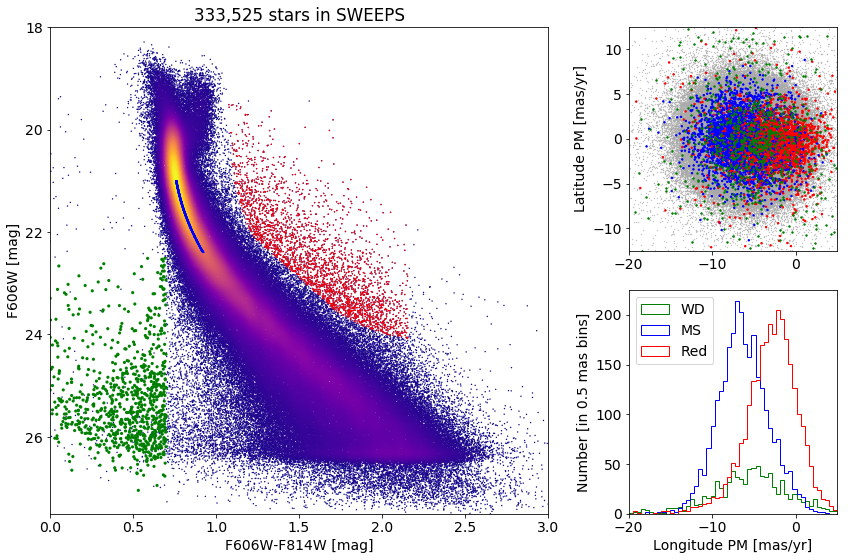

In [29]:
w = np.where((RminusI > 0) & (RminusI < 3) & good)[0]

wwd = np.where((RminusI < 0.7) 
               & (RminusI > 0) 
               & (f606w > 22.5) 
               & good 
               & (tab['lpm'] < 5) 
               & (tab['lpm'] > -20))[0]
xwd = np.array(RminusI[wwd])
ywd = np.array(f606w[wwd])

# Calculate the point density
x = np.array(RminusI[w])
y = np.array(f606w[w])

myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.1)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

# locate ridge line in magnitude as a function of color
xloc = ridge_color(y)
ridgex = ridge_color(axes[1][wx])

# locate ridge line in color as function of magnitude
yloc = ridge_mag(x)
x1 = x[np.isfinite(yloc)]
wy = np.where((axes[0] >= x1.min()) & (axes[0] <= x1.max()))[0]
ridgey = ridge_mag(axes[0][wy])

# low-noise objects
print("Selected {:,} low-noise objects".format(len(w)))

# red objects
ylim = yloc - 1.5 - (yloc - 25.0).clip(0)/(1+10.0**(-0.4*(yloc-26.0)))
wred = np.where((y<25) & (y > 19.5) & (y < ylim) & (x-xloc > 0.35))[0]
#wred = np.where((y<25) & (y > 19.5) & ((y-yloc) < -1.5)
#                   & (x-xloc > 0.3))[0]
#                   & (x > 1.1) & (x < 2.5) & (x-xloc > 0.2))[0]
print("Selected {:,} red objects".format(len(wred)))
# main sequence objects
wmain = np.where((y>21) & (y<22.4) & (np.abs(x-xloc) < 0.1))[0]
print("Initially selected {:,} MS objects".format(len(wmain)))
# sort by distance from ridge and select the closest
wmain = wmain[np.argsort(np.abs(x[wmain]-xloc[wmain]))]
wmain = wmain[:len(wred)]
print("Selected {:,} MS objects closest to ridge".format(len(wmain)))

pylab.rcParams.update({'font.size': 14})

pylab.figure(1,(12,8))
pylab.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
pylab.scatter(xs,ys,c=zs,s=2,cmap='plasma',edgecolor='')
pylab.scatter(x[wred],y[wred],c='red',s=2,edgecolor='')
pylab.scatter(x[wmain],y[wmain],c='blue',s=2,edgecolor='')
pylab.scatter(xwd,ywd,c='green',s=10,edgecolor='')
pylab.xlim(0,3)
pylab.ylim(18,27.5)
pylab.xlabel('F606W-F814W [mag]')
pylab.ylabel('F606W [mag]')
pylab.gca().invert_yaxis()
pylab.title('{:,} stars in SWEEPS'.format(len(x)))

lrange = (-20,5)
brange = (-12.5,12.5)

# plot MS and red points in random order
wsel = w[np.append(wmain,wred)]
colors = np.array(['blue']*len(wsel))
colors[len(wmain):] = 'red'
irs = np.argsort(np.random.random(len(wsel)))
wsel = wsel[irs]
colors = colors[irs]

pylab.subplot2grid((2,3), (0,2), rowspan=1, colspan=1)
pylab.scatter(tab['lpm'][w],tab['bpm'][w],c='darkgray',s=0.1)
pylab.scatter(tab['lpm'][wsel],tab['bpm'][wsel],c=colors,s=2)
pylab.scatter(tab['lpm'][wwd],tab['bpm'][wwd],c='green',s=2)
pylab.xlim(*lrange)
pylab.ylim(*brange)
pylab.ylabel('Latitude PM [mas/yr]')

pylab.subplot2grid((2,3), (1,2), rowspan=1, colspan=1)
bin = 0.5
bincount = int((lrange[1]-lrange[0])/bin + 0.5) + 1
pylab.hist(tab['lpm'][wwd], range=lrange, bins=bincount, label='WD', color='green', 
           histtype='step')
pylab.hist(tab['lpm'][w[wmain]], range=lrange, bins=bincount, label='MS', color='blue', 
           histtype='step')
pylab.hist(tab['lpm'][w[wred]], range=lrange, bins=bincount, label='Red', color='red', 
           histtype='step')
pylab.xlim(*lrange)
pylab.xlabel('Longitude PM [mas/yr]')
pylab.ylabel('Number [in {:.2} mas bins]'.format(bin))
pylab.legend(loc='upper left')
pylab.tight_layout()
# pylab.savefig('{}sweeps_calamida_wd.png'.format(resPath))

## White dwarf mean PM and uncertainity

In [30]:
norm=1.0/np.sqrt(len(tab['lpm'][wwd]))
print("WD PM mean +- stdev longitude {:.2f} +- {:.3f} latitude {:.2f} +- {:.3f}".format(
    np.mean(tab['lpm'][wwd]), norm*np.std(tab['lpm'][wwd]),
    np.mean(tab['bpm'][wwd]), norm*np.std(tab['bpm'][wwd])
    ))

WD PM mean +- stdev longitude -5.60 +- 0.152 latitude -0.03 +- 0.245


## WDs generally closer to bulge (MS) PM distribution

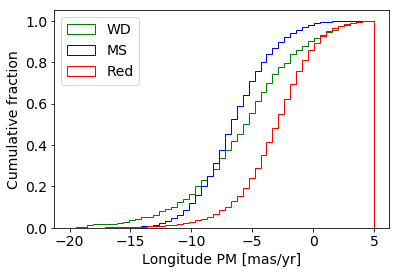

In [31]:
bin = 0.5
bincount = int((lrange[1]-lrange[0])/bin + 0.5) + 1
pylab.hist(tab['lpm'][wwd], range=lrange, bins=bincount, label='WD', color='green', 
           histtype='step', normed=1, cumulative=1)
pylab.hist(tab['lpm'][w[wmain]], range=lrange, bins=bincount, label='MS', color='blue', 
           histtype='step', normed=1, cumulative=1)
pylab.hist(tab['lpm'][w[wred]], range=lrange, bins=bincount, label='Red', color='red', 
           histtype='step', normed=1, cumulative=1)
pylab.xlabel('Longitude PM [mas/yr]')
pylab.ylabel('Cumulative fraction'.format(bin))
pylab.legend(loc='upper left')
pylab.show()

## Look for quasar candidates (low PM blue stars)  <a class="anchor" id="qsocan"></a>
Note this includes all objects, not just "good" objects with low mag noise, because quasars might be variable too.

<Table length=14>
    ObjID             RA                 Dec                RAerr        ...         dT              yrStart             yrEnd       
    int64          float64             float64             float64       ...      float64            float64            float64      
------------- ------------------ ------------------- ------------------- ... ------------------ ------------------ ------------------
4000710313439 269.74005171773325 -29.196032473369662  0.6265964047671119 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000710257520 269.76634477578085 -29.223310166797457  0.7010607226863969 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000710307965  269.7417955221381 -29.198593859432016  0.9205935728204635 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000710352240  269.7337926320315  -29.18139487545298  0.6946356814006966 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000710347699  269.7783405856686  -29.17911931116647 0.41155778832388173 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000710305789  269.7500895465239 -29.199706962876274  1.2377985340299074 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000710287023 269.73049137354224 -29.208786514685837  0.5886781414210673 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000711198572  269.7837898799627 -29.171058346187387 0.24289061146320284 ... 10.997621905233284  2003.436727359001 2014.4343492642342
4000711114267 269.77699533206413 -29.213020339932903    4.24137055513596 ... 12.136400136689947  2003.436727359001  2015.573127495691
4000710335454  269.7613531455845 -29.187206361070864   7.474297329875963 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000710273567  269.7541240409338  -29.21578796024474   4.748214164796449 ... 11.341399291029212  2003.436727359001 2014.7781266500303
4000710273213   269.762844233717 -29.215993073596458  2.8491412759641146 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000710327380  269.7667196275462 -29.189803905653022  1.4975661577032107 ... 11.341399291029212  2003.436727359001 2014.7781266500303
4000710296308  269.7744892710409  -29.20439243403908  3.8554370972569254 ... 11.371732905164137 2003.4361796620085 2014.8079125671727

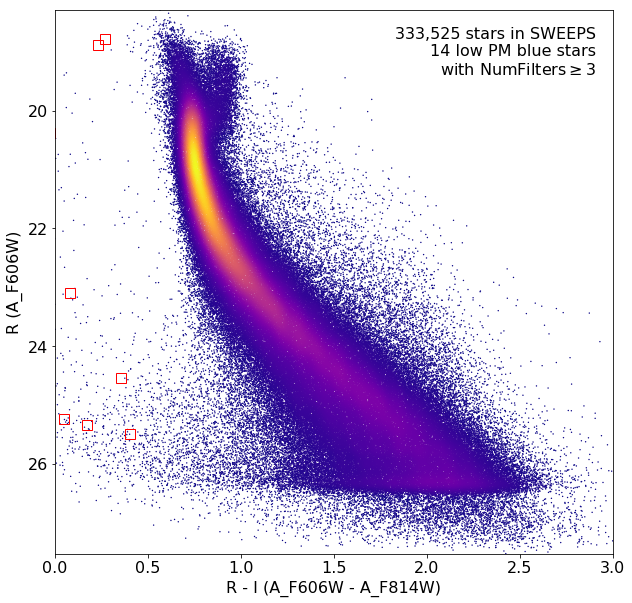

In [32]:
wqso1 = np.where((RminusI < 0.5) 
                & (np.sqrt(tab['bpm']**2+tab['lpm']**2) < 1.0) 
                & (tab['NumFilters'] > 2))[0]
wqso1 = wqso1[np.argsort(f606w[wqso1])]

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,10))
pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
pylab.plot(RminusI[wqso1],f606w[wqso1],'rs',markersize=10,fillstyle='none')
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
pylab.gca().invert_yaxis()
pylab.xlabel('R - I (A_F606W - A_F814W)')
pylab.ylabel('R (A_F606W)')
pylab.text(0.97,0.97, """{:,} stars in SWEEPS
{} low PM blue stars
with NumFilters$\\geq3$""".format(len(x),len(wqso1)),
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
tab[wqso1]

Plotting 14 objects


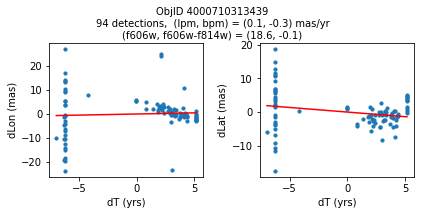

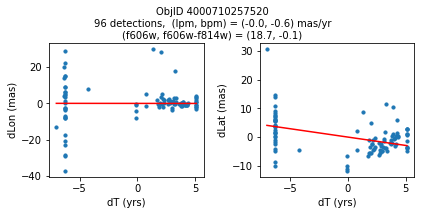

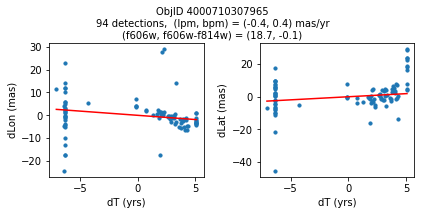

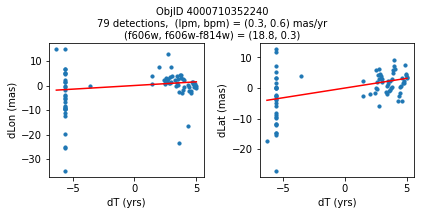

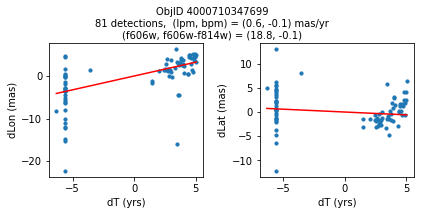

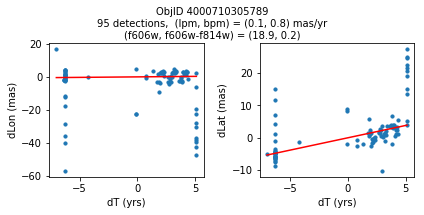

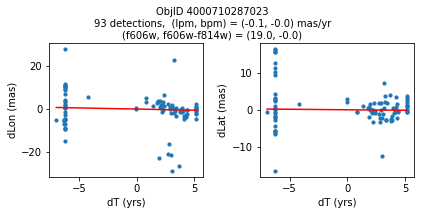

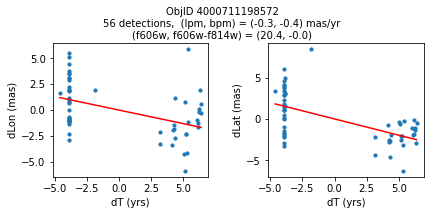

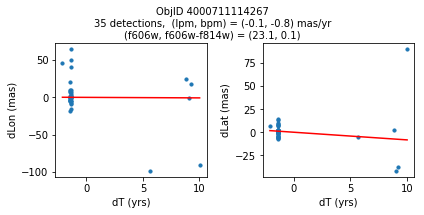

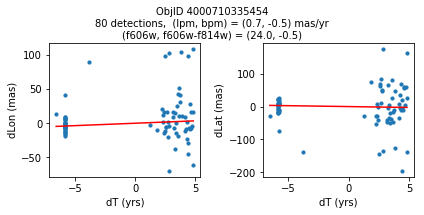

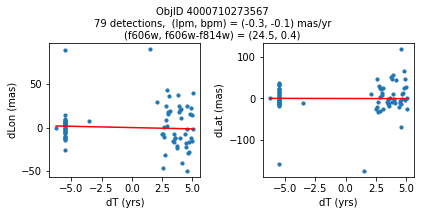

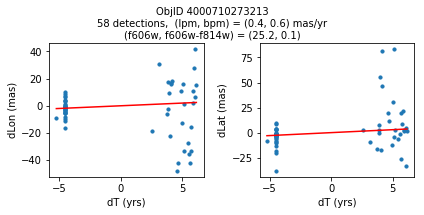

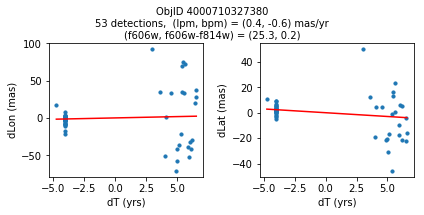

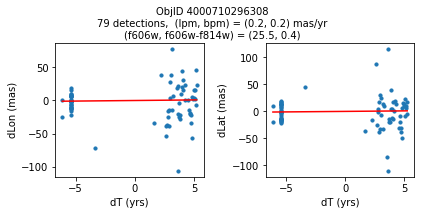

In [33]:
objid = tab['ObjID']
print("Plotting {} objects".format(len(wqso1)))
for o in objid[wqso1]:
    positions(o,jobs=jobs)

### Try again with different criteria on proper motion fit quality

<Table length=10>
    ObjID             RA                 Dec                RAerr        ...         dT              yrStart             yrEnd       
    int64          float64             float64             float64       ...      float64            float64            float64      
------------- ------------------ ------------------- ------------------- ... ------------------ ------------------ ------------------
4000710347699  269.7783405856686  -29.17911931116647 0.41155778832388173 ... 11.371185208171667  2003.436727359001 2014.8079125671727
4000711253077  269.6915378419676  -29.24020145019322  0.4704881733739859 ...   3.00678120252487 2011.8016761776817 2014.8084573802066
4000711347522 269.70065127433986 -29.232034952664744 0.45813739460650355 ...   3.00678120252487 2011.8016761776817 2014.8084573802066
4000709025473 269.82873131529516  -29.19512257484812  0.5411363937542479 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000710279756  269.7207706977463 -29.212308555948887 0.41374484392259747 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000711345953 269.71277619272627  -29.23130608012401  0.4732191836487131 ...   3.00678120252487 2011.8016761776817 2014.8084573802066
4000709014231  269.8069522092499  -29.20021994406481  0.3834521659779482 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000710326758 269.75587447129374 -29.189995188046638 0.39923238020201557 ... 12.138936292937231  2003.436727359001 2015.5756636519384
4000711198572  269.7837898799627 -29.171058346187387 0.24289061146320284 ... 10.997621905233284  2003.436727359001 2014.4343492642342
4000724763944  269.7747901164537  -29.26523403383687 0.43377673171406406 ...   3.00678170959782  2011.801494066038 2014.8082757756358

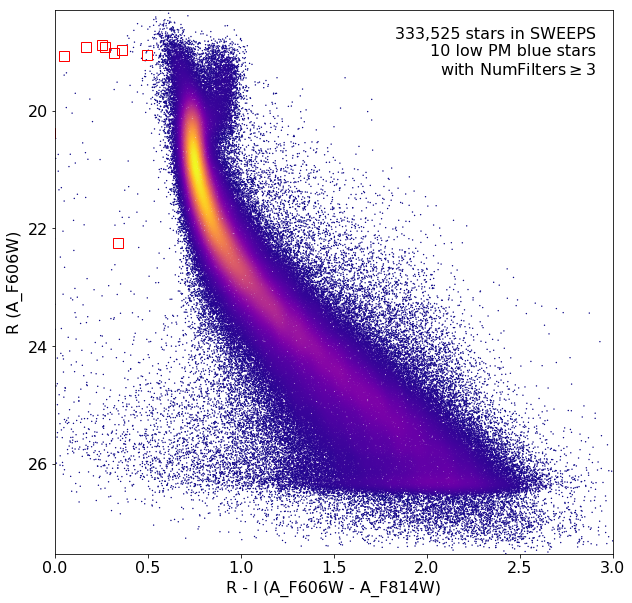

In [34]:
wqso2 = np.where((RminusI < 0.5) 
                & (np.sqrt(tab['bpm']**2+tab['lpm']**2) < 2.0)
                & (np.sqrt(tab['bpmerr']**2+tab['lpmerr']**2) < 2.0)
                & (tab['pmdev'] < 4.0)
                )[0]
wqso2 = wqso2[np.argsort(f606w[wqso2])]

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,10))
pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
pylab.plot(RminusI[wqso2],f606w[wqso2],'rs',markersize=10,fillstyle='none')
pylab.xlim((xedge[0],xedge[-1]))
pylab.ylim((yedge[0],yedge[-1]))
pylab.gca().invert_yaxis()
pylab.xlabel('R - I (A_F606W - A_F814W)')
pylab.ylabel('R (A_F606W)')
pylab.text(0.97,0.97, """{:,} stars in SWEEPS
{} low PM blue stars
with NumFilters$\\geq3$""".format(len(x),len(wqso2)),
       horizontalalignment='right', verticalalignment='top',
       transform=pylab.gca().transAxes)
tab[wqso2]

Plotting 10 objects


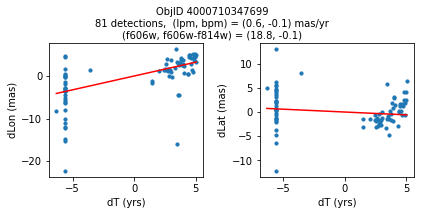

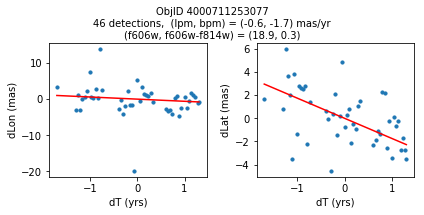

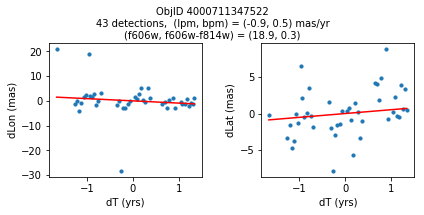

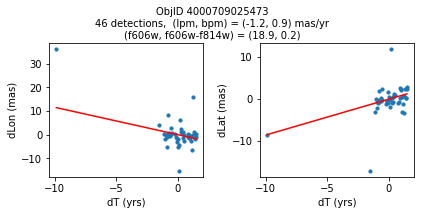

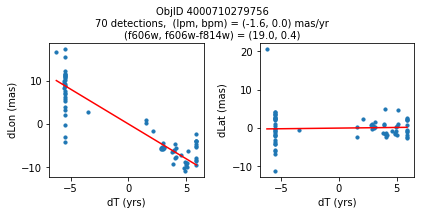

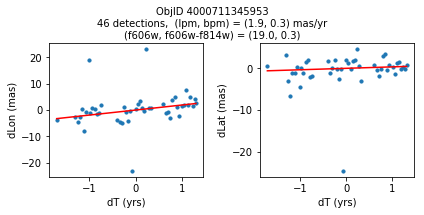

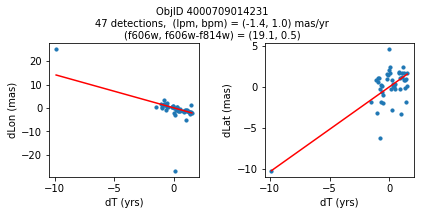

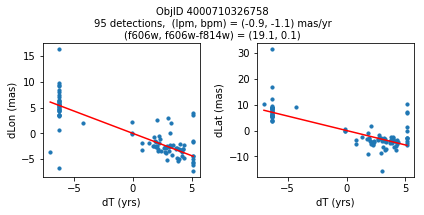

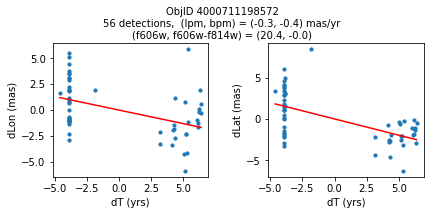

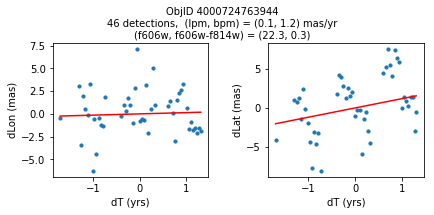

In [35]:
objid = tab['ObjID']
print("Plotting {} objects".format(len(wqso2)))
for o in objid[wqso2]:
    positions(o,jobs=jobs)

# High Proper Motion Objects  <a class="anchor" id="hpm"></a>

Get a list of objects with high, accurately measured proper motions.
Proper motions are measured relative to the main sequence sample (Galactic center approximately).

kde took 3.8 sec
Plotting 98805 of 333743 points


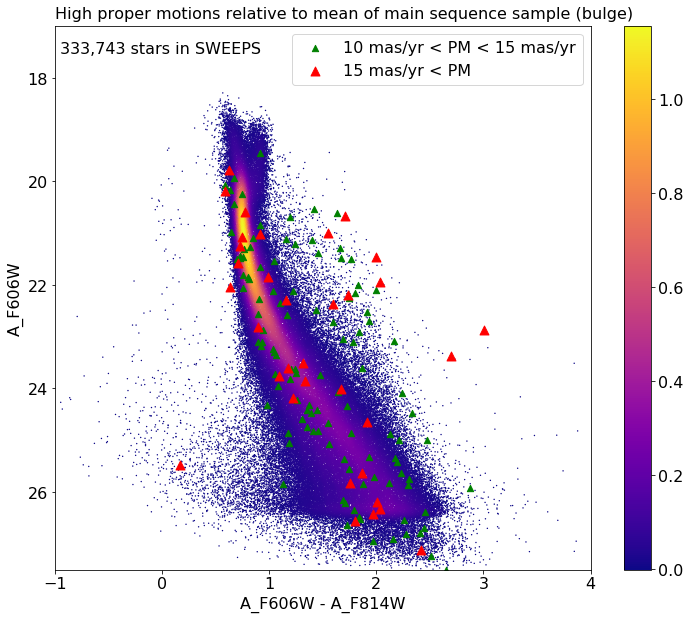

In [36]:
f606w = tab['a_f606w']
f814w = tab['a_f814w']
RminusI = f606w-f814w
lpm0 = np.array(tab['lpm'])
bpm0 = np.array(tab['bpm'])
lpmerr0 = np.array(tab['lpmerr'])
bpmerr0 = np.array(tab['bpmerr'])
pmtot0 = np.sqrt((bpm0-bpmmain)**2+(lpm0-lpmmain)**2)
pmerr0 = np.sqrt(bpmerr0**2+lpmerr0**2)

# sort samples by decreasing PM
wpml = np.where((pmtot0 > 12) & (pmtot0 < 15) & (pmerr0 < 1.0) & good)[0]
wpml = wpml[np.argsort(-pmtot0[wpml])]
xpml = np.array(RminusI[wpml])
ypml = np.array(f606w[wpml])

wpmh = np.where((pmtot0 > 15) & (pmerr0 < 1.0) & good)[0]
wpmh = wpmh[np.argsort(-pmtot0[wpmh])]
xpmh = np.array(RminusI[wpmh])
ypmh = np.array(f606w[wpmh])

# Calculate the point density
w = np.where((RminusI > -1) & (RminusI < 4) & good)[0]
x = np.array(RminusI[w])
y = np.array(f606w[w])
t0 = time.time()
myPDF,axes = fastKDE.pdf(x,y,numPoints=2**10+1)
print("kde took {:.1f} sec".format(time.time()-t0))

# interpolate to get z values at points
finterp = RectBivariateSpline(axes[1],axes[0],myPDF)
z = finterp(y,x,grid=False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs<0.05)[0]
print("Plotting {} of {} points".format(len(wran),len(zs)))
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.scatter(xs, ys, c=zs, s=2, edgecolor='', cmap='plasma')
pylab.autoscale(tight=True)
pylab.xlabel('A_F606W - A_F814W')
pylab.ylabel('A_F606W')
pylab.gca().invert_yaxis()
pylab.xlim(-1,4)
pylab.ylim(27.5,17.0)
pylab.colorbar()
pylab.scatter(xpml, ypml, s=40, c="green", marker ="^",  label='10 mas/yr < PM < 15 mas/yr')
pylab.scatter(xpmh, ypmh, s=80, c="red", marker ="^",  label='15 mas/yr < PM')
pylab.text(0.,0.95,'High proper motions relative to mean of main sequence sample (bulge) \n \n {:,} stars in SWEEPS'.format(len(x)),
       horizontalalignment='left',
       transform=pylab.gca().transAxes)
pylab.legend(loc='upper right')
# pylab.savefig("{}sweeps_colormag_highpm.png".format(resPath))

Plotting 34 objects


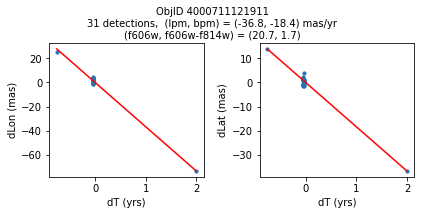

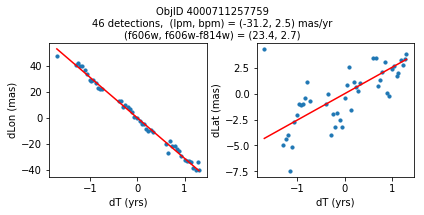

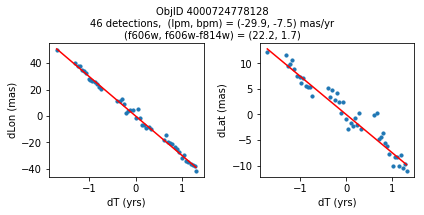

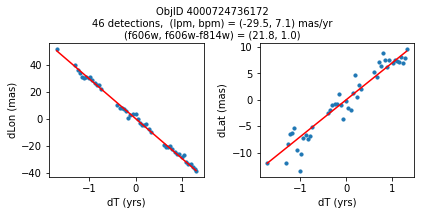

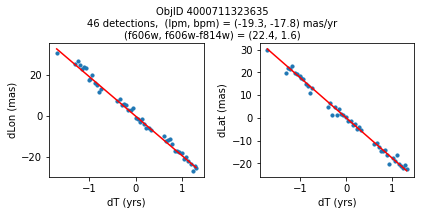

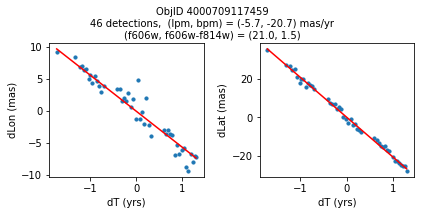

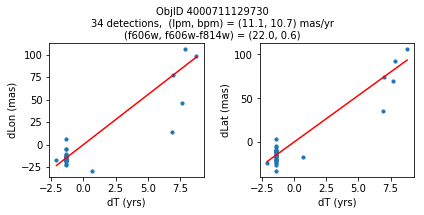

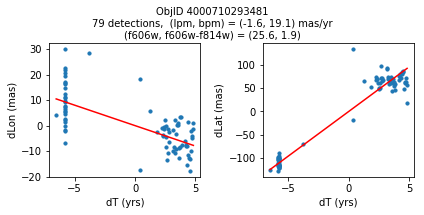

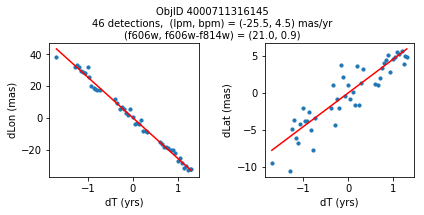

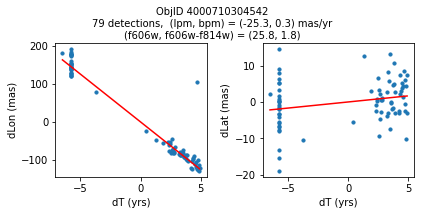

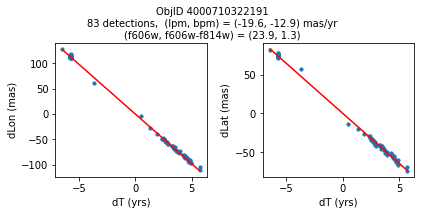

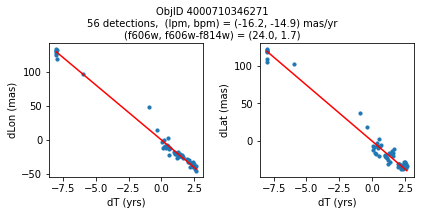

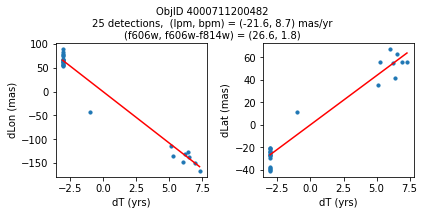

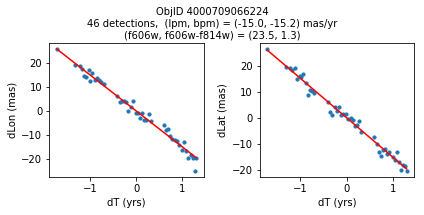

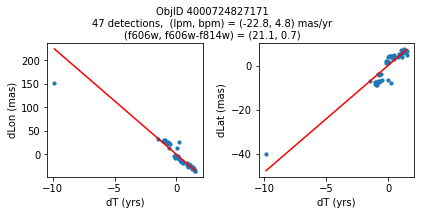

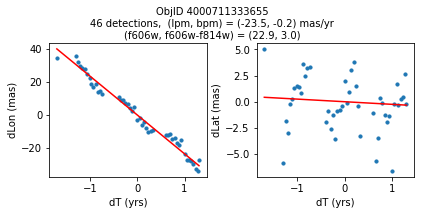

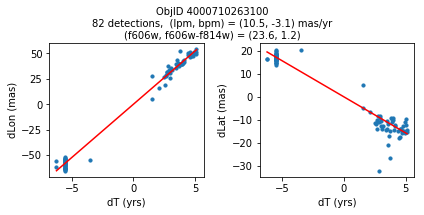

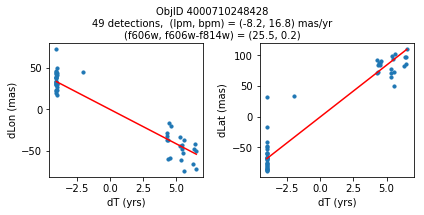

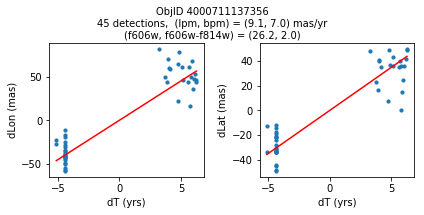

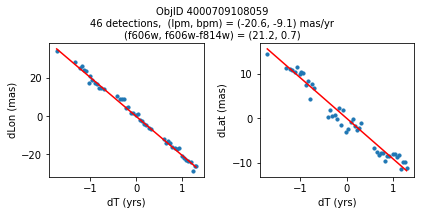

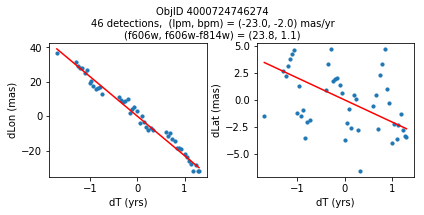

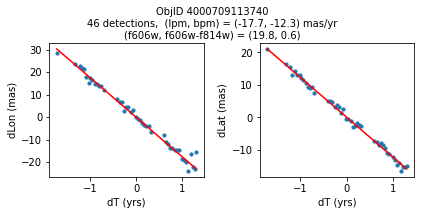

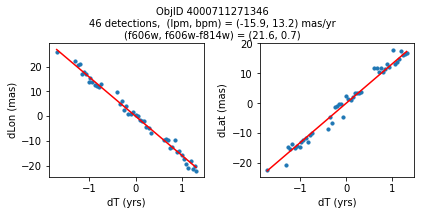

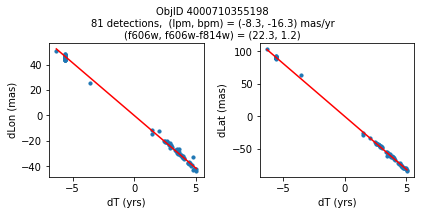

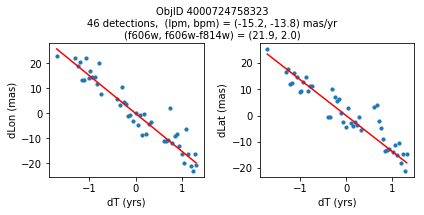

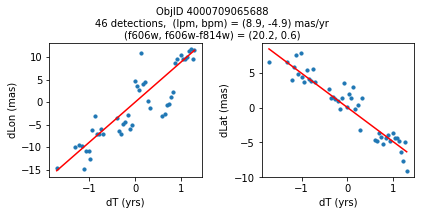

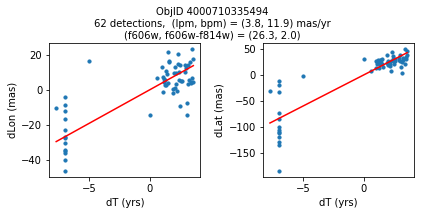

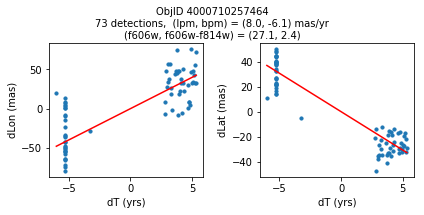

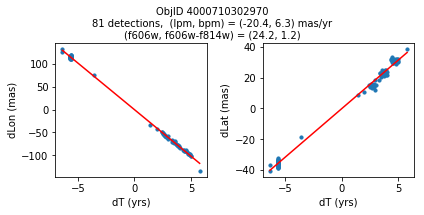

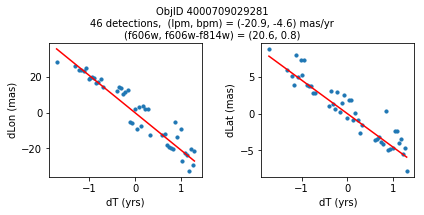

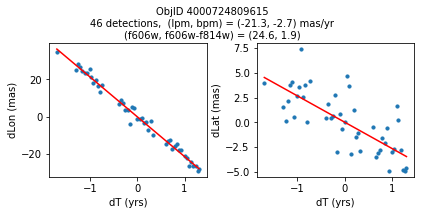

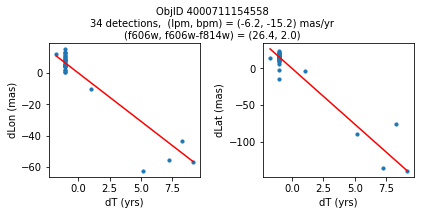

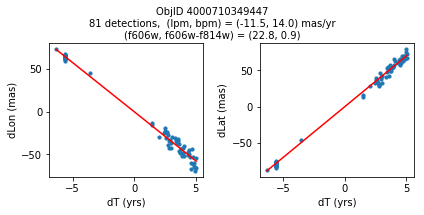

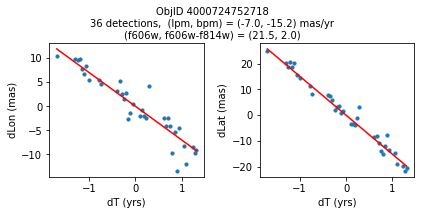

In [37]:
print("Plotting {} objects".format(len(wpmh)))
for o in tab["ObjID"][wpmh]:
    positions(o,jobs=jobs)

# Very red high proper motion objects

Plotting 4 objects


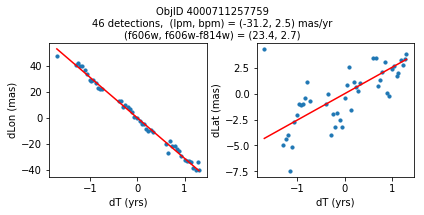

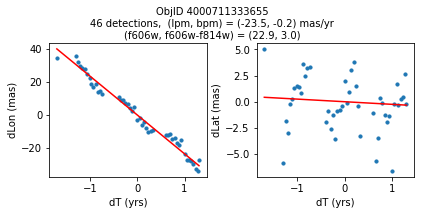

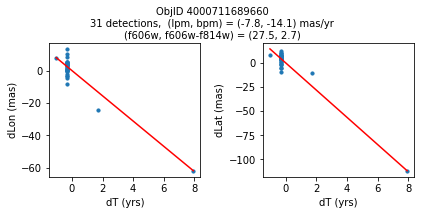

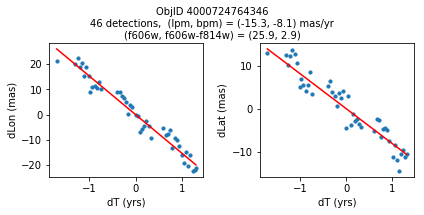

In [38]:
wpmred =  np.where((pmtot0 > 12) & (pmerr0 < 1.0) & (RminusI > 2.6) & good)[0]
print("Plotting {} objects".format(len(wpmred)))
for o in tab["ObjID"][wpmred]:
    positions(o,jobs=jobs)

# Very blue high proper motion objects

Plotting 12 objects


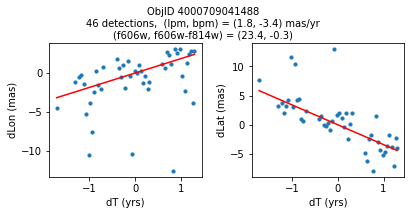

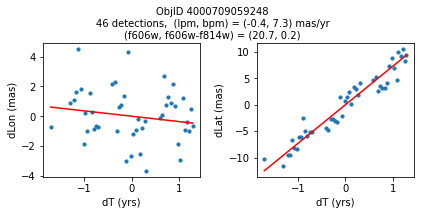

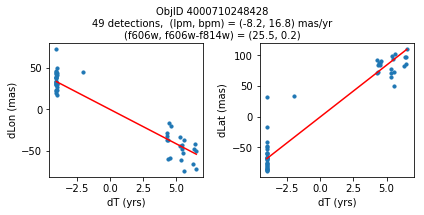

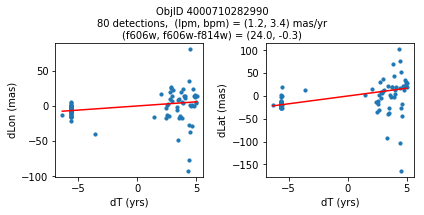

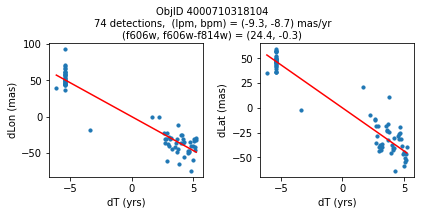

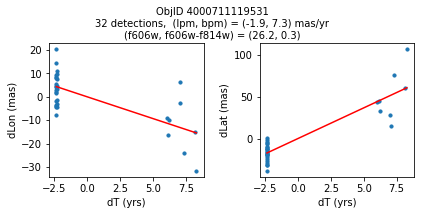

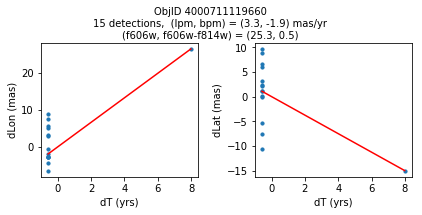

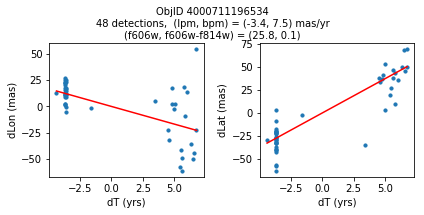

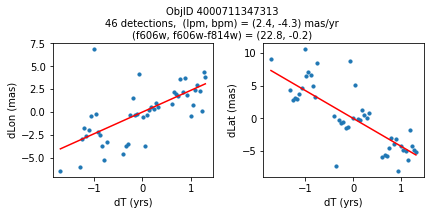

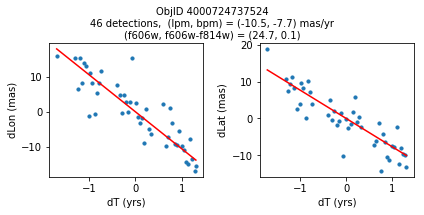

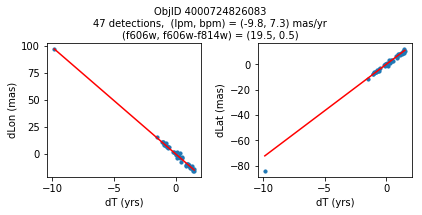

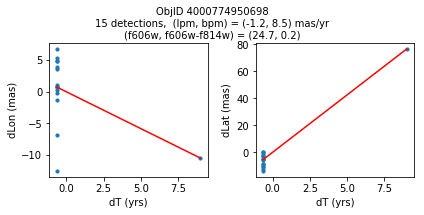

In [39]:
wpmblue =  np.where((pmtot0 > 8) & (pmerr0 < 1.0) & (RminusI < 0.5) & good)[0]
print("Plotting {} objects".format(len(wpmblue)))
for o in tab["ObjID"][wpmblue]:
    positions(o,jobs=jobs)

# Get HLA cutout images for selected objects  <a class="anchor" id="cutouts"></a>

Get HLA color cutout images for the high-PM objects.  The `query_hla` function gets a table of all the color images that are available at a given position using the f814w+f606w filters.  The `get_image` function reads a single cutout image (as a JPEG color image) and returns a PIL image object.

See the documentation on [HLA VO services](http://hla.stsci.edu/hla_help.html#services) and the [fitscut image cutout service](http://hla.stsci.edu/fitscutcgi_interface.html) for more information on the web services being used.

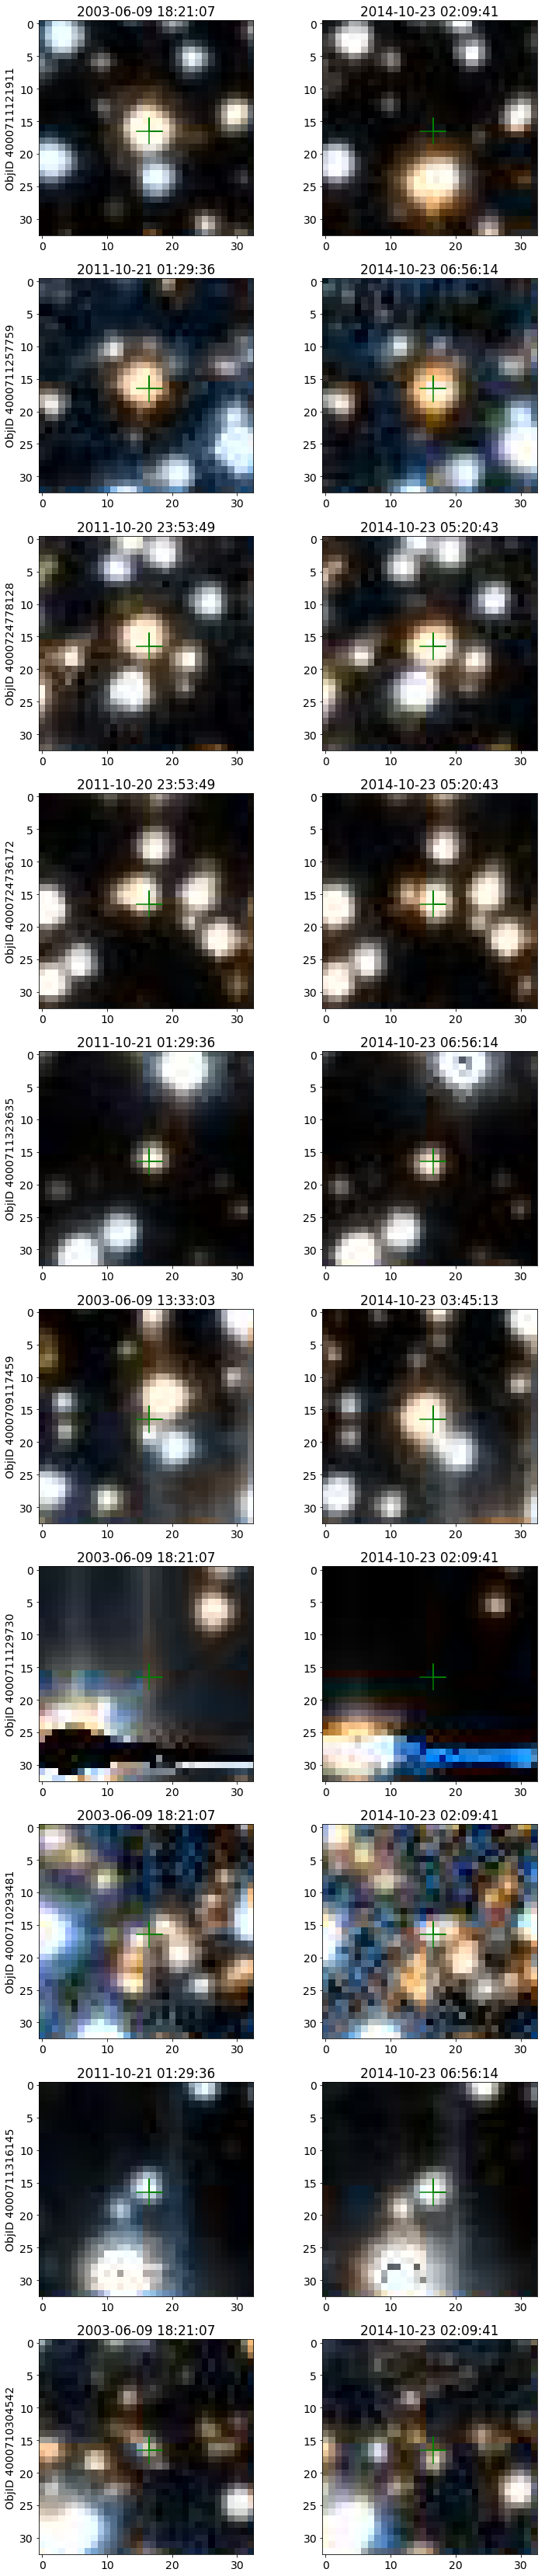

In [40]:
from PIL import Image
from io import BytesIO

def query_hla(ra,dec,size=0.0,imagetype="color",inst="ACS",format="image/jpeg",
              spectral_elt=("f814w","f606w"),autoscale=95.0,asinh=1,
              naxis=33):
    # convert a list of filters to a comma-separated string
    if not isinstance(spectral_elt,str):
        spectral_elt = ",".join(spectral_elt)
    siapurl = ("https://hla.stsci.edu/cgi-bin/hlaSIAP.cgi?"
               "pos={ra},{dec}&size={size}&imagetype={imagetype}&inst={inst}"
               "&format={format}&spectral_elt={spectral_elt}"
               "&autoscale={autoscale}&asinh={asinh}"
               "&naxis={naxis}").format(**locals())
    votable = Table.read(siapurl,format="votable")
    return votable

def get_image(url):
    
    """Get image from a URL"""
    
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im

# display earliest and latest images side-by-side
# wsel = wpmred
# wsel = wpmblue
# top 10 highest PM objects
wsel = wpmh[:10]
nim = len(wsel)
icols = 1        # objects per row
ncols = 2*icols  # two images for each object
nrows = (nim+icols-1)//icols

imsize = 33
xcross = np.array([-1,1,0,0,0])*2 + imsize/2
ycross = np.array([0,0,0,-1,1])*2 + imsize/2

pylab.rcParams.update({"font.size":14})
pylab.figure(1,(12, (12/ncols)*nrows))
for jim, i in enumerate(wsel):
    hlatab = query_hla(tab["RA"][i],tab["Dec"][i],naxis=imsize)
    # sort by observation date
    hlatab = hlatab[np.argsort(hlatab['StartTime'])]
    k = 0
    im1 = get_image(hlatab['URL'][k])
    pylab.subplot(nrows,ncols,2*jim+1)
    pylab.imshow(im1,origin="upper")
    pylab.plot(xcross,ycross,'g')
    pylab.title(hlatab['StartTime'][k].decode('utf-8'))
    pylab.ylabel("ObjID {}".format(tab["ObjID"][i]))

    k = -1
    im2 = get_image(hlatab['URL'][k])
    pylab.subplot(nrows,ncols,2*jim+2)
    pylab.imshow(im2,origin="upper")
    pylab.plot(xcross,ycross,'g')
    pylab.title(hlatab['StartTime'][k].decode('utf-8'))

### Look at the entire collection of images for the highest PM object

    ObjID             RA                Dec              a_f606w           a_f814w              bpm                lpm                 yr                dT       
------------- ----------------- ------------------- ----------------- ------------------ ------------------ ------------------ ----------------- -----------------
4000711121911 269.7367256594695 -29.209699919117618 20.67275047302246 18.963199615478516 -18.43788346257518 -36.80145933087569 2004.194238143401 2.749260607770275
7.6 s: finished 10 of 77
15.2 s: finished 20 of 77
22.9 s: finished 30 of 77
30.4 s: finished 40 of 77
37.9 s: finished 50 of 77
45.4 s: finished 60 of 77
52.8 s: finished 70 of 77
60.2 s: finished 77


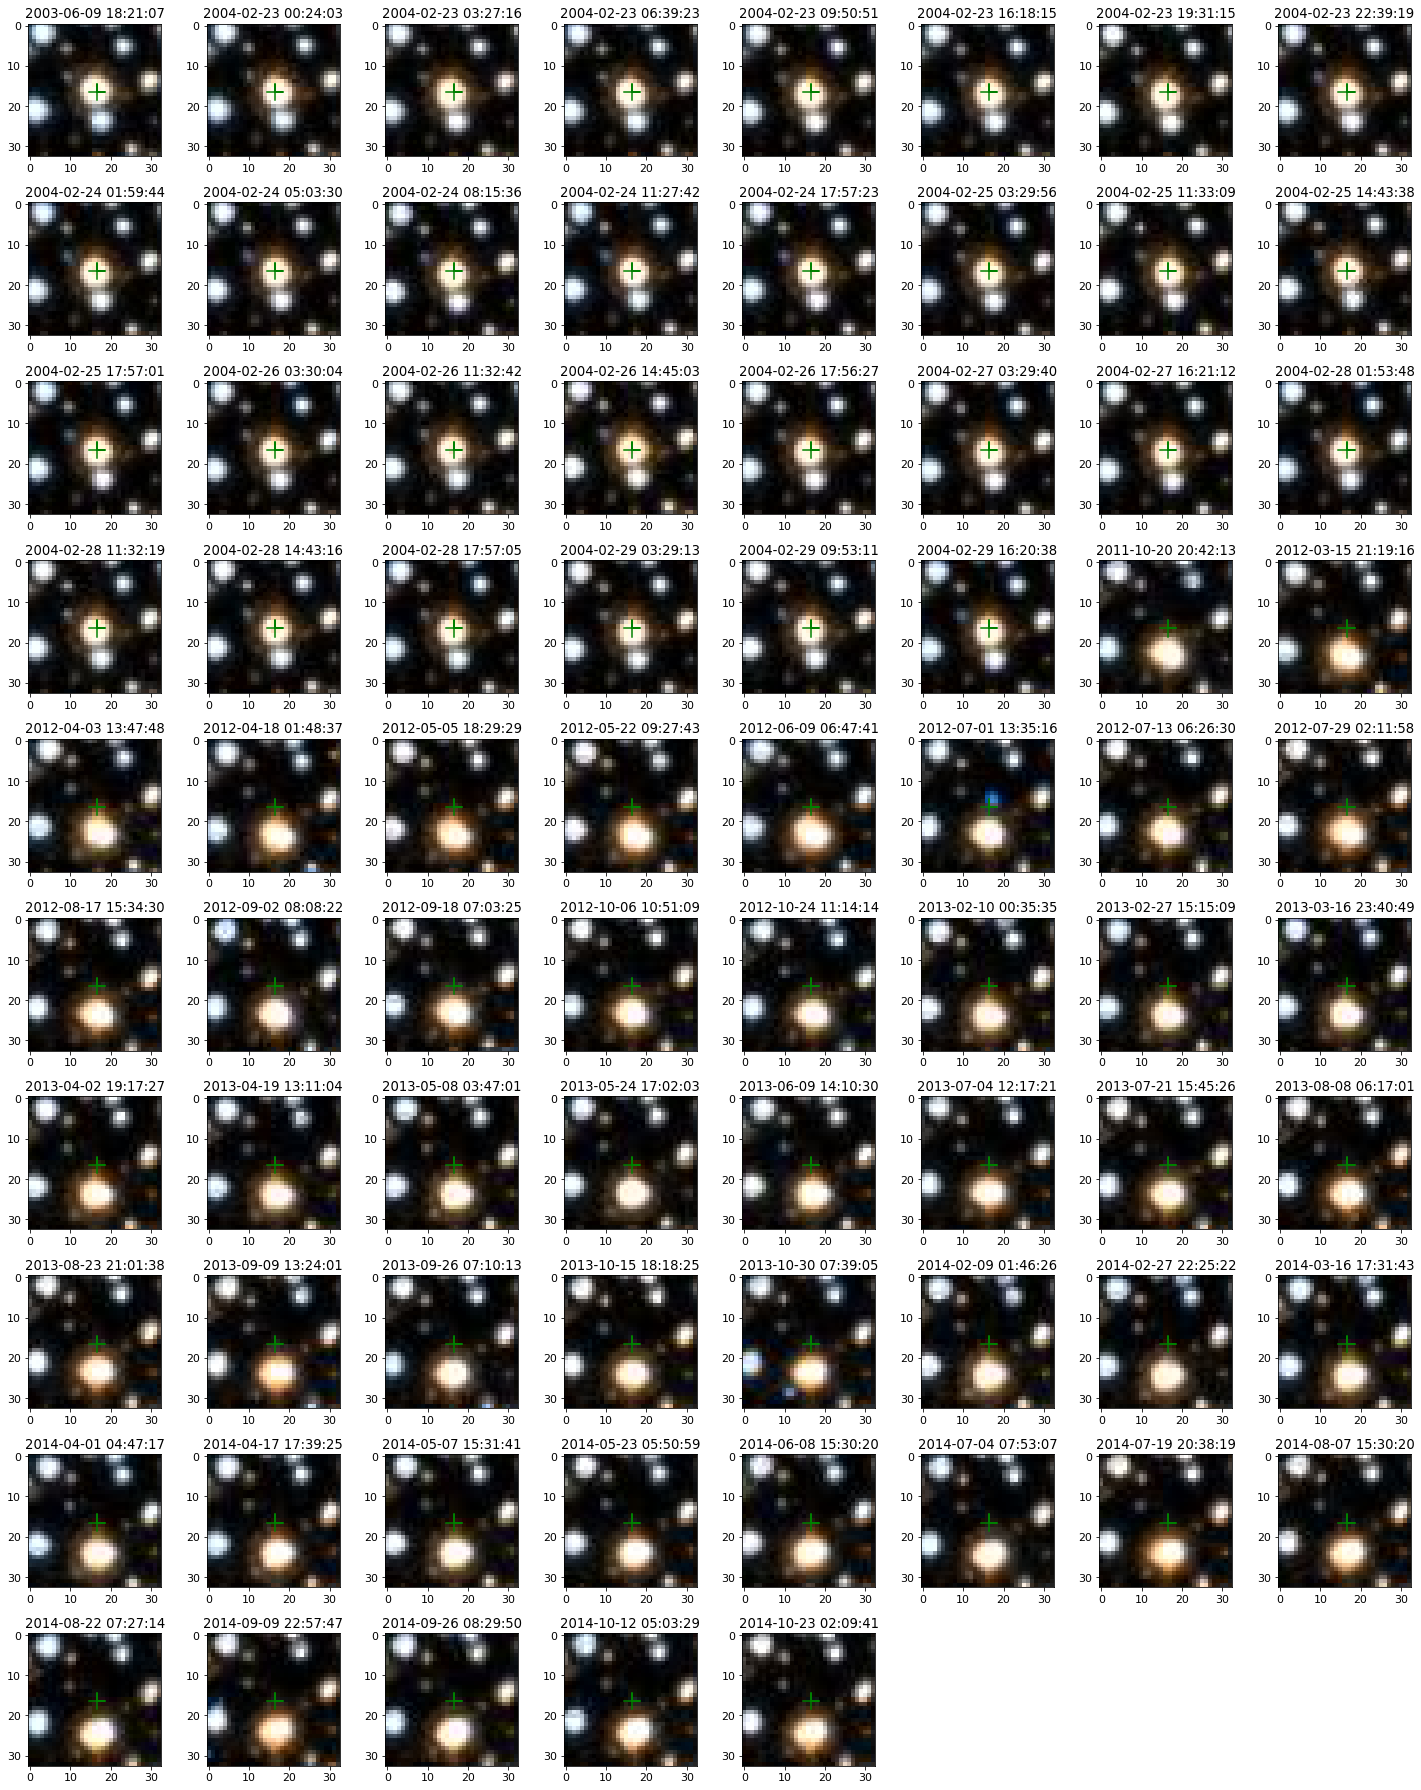

In [41]:
i = wpmh[0]
print(tab['ObjID','RA','Dec','a_f606w','a_f814w','bpm','lpm','yr','dT'][i])
imsize = 33
hlatab = query_hla(tab["RA"][i],tab["Dec"][i],naxis=imsize)
# sort by observation date
hlatab = hlatab[np.argsort(hlatab['StartTime'])]

nim = len(hlatab)
ncols = 8
nrows = (nim+ncols-1)//ncols

xcross = np.array([-1,1,0,0,0])*2 + imsize/2
ycross = np.array([0,0,0,-1,1])*2 + imsize/2

pylab.rcParams.update({"font.size":11})
pylab.figure(1,(20, (20/ncols)*nrows))
t0 = time.time()
for k in range(nim):
    im1 = get_image(hlatab['URL'][k])
    pylab.subplot(nrows,ncols,k+1)
    pylab.imshow(im1,origin="upper")
    pylab.plot(xcross,ycross,'g')
    pylab.title(hlatab['StartTime'][k].decode('utf-8'))
    if ((k+1) % 10)==0:
        print("{:.1f} s: finished {} of {}".format(time.time()-t0,k+1,nim))
pylab.tight_layout()
print("{:.1f} s: finished {}".format(time.time()-t0,nim))